<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [19]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [20]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [21]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="9",
                             total_timesteps=6000000)

load
Logging to ppo/9_7
-----------------------------------
| time/              |            |
|    fps             | 118        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.40348062 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014169915 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0237     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.99        |
|    n_updates            | 10          |
|    policy_gradient_l

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 12          |
|    time_elapsed         | 220         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.01741166  |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.8       |
|    explained_variance   | -0.0334     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0208     |
|    reward               | -0.12370278 |
|    std                  | 1.02        |
|    value_loss           | 20.1        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3262423.12
total_reward: 2262423.12
total_cost: 310798.82
total_trades: 78026
Sharpe: 0.62

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 22          |
|    time_elapsed         | 405         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.025557566 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.3       |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0182     |
|    reward               | 4.424101    |
|    std                  | 1.04        |
|    value_loss           | 33          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 32          |
|    time_elapsed         | 589         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.028471969 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0208      |
|    learning_rate        | 0.00025     |
|    loss                 | 20.4        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0177     |
|    reward               | -0.64046746 |
|    std                  | 1.06        |
|    value_loss           | 48.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 33 

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 42          |
|    time_elapsed         | 774         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.033209324 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | -0.00132    |
|    learning_rate        | 0.00025     |
|    loss                 | 33.8        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00681    |
|    reward               | -0.47725743 |
|    std                  | 1.08        |
|    value_loss           | 78          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 52          |
|    time_elapsed         | 954         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.015190747 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | 0.0273      |
|    learning_rate        | 0.00025     |
|    loss                 | 45.5        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00988    |
|    reward               | -1.1449255  |
|    std                  | 1.09        |
|    value_loss           | 95.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 62          |
|    time_elapsed         | 1140        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.022945713 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.0396      |
|    learning_rate        | 0.00025     |
|    loss                 | 88.4        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0101     |
|    reward               | 6.096223    |
|    std                  | 1.1         |
|    value_loss           | 142         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 63       

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 72          |
|    time_elapsed         | 1328        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.018079579 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.000676    |
|    learning_rate        | 0.00025     |
|    loss                 | 73.9        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00942    |
|    reward               | -17.568949  |
|    std                  | 1.12        |
|    value_loss           | 163         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 73 

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 82          |
|    time_elapsed         | 1514        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.044670146 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.8       |
|    explained_variance   | 0.0348      |
|    learning_rate        | 0.00025     |
|    loss                 | 48.3        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0016     |
|    reward               | 0.025694795 |
|    std                  | 1.14        |
|    value_loss           | 177         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 83       

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 92          |
|    time_elapsed         | 1698        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.02354655  |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.3       |
|    explained_variance   | -0.00808    |
|    learning_rate        | 0.00025     |
|    loss                 | 487         |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0027     |
|    reward               | -0.97534776 |
|    std                  | 1.16        |
|    value_loss           | 707         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 93       

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 102         |
|    time_elapsed         | 1886        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.029268403 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.7       |
|    explained_variance   | -0.00988    |
|    learning_rate        | 0.00025     |
|    loss                 | 86.6        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00967    |
|    reward               | -1.3604256  |
|    std                  | 1.17        |
|    value_loss           | 100         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 4254983.27
total_reward: 3254983.27
total_cost: 295521.85
total_trades: 73256
Sharpe: 0.745
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 112         |
|    time_elapsed         | 2072        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.028734215 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.2       |
|    explained_variance   | 0.0277      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.7        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0077     |
|    reward               | -0.6914373  |
|    std                  | 1.19        |
|    value_loss           | 97.7        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 122         |
|    time_elapsed         | 2259        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.04543548  |
|    clip_fraction        | 0.319       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.7       |
|    explained_variance   | -0.0153     |
|    learning_rate        | 0.00025     |
|    loss                 | 67.8        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00738    |
|    reward               | -0.18316938 |
|    std                  | 1.21        |
|    value_loss           | 105         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 123   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 132         |
|    time_elapsed         | 2447        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.044146698 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.2       |
|    explained_variance   | 0.00969     |
|    learning_rate        | 0.00025     |
|    loss                 | 15          |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.0019     |
|    reward               | 2.5783622   |
|    std                  | 1.23        |
|    value_loss           | 31.7        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 110       |
|    iterations           | 133       |


-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 142         |
|    time_elapsed         | 2633        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.051289707 |
|    clip_fraction        | 0.315       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.5       |
|    explained_variance   | -0.138      |
|    learning_rate        | 0.00025     |
|    loss                 | 47.2        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.00229     |
|    reward               | -1.6205779  |
|    std                  | 1.25        |
|    value_loss           | 92.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 143   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 152        |
|    time_elapsed         | 2816       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.02918168 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48        |
|    explained_variance   | 0.00751    |
|    learning_rate        | 0.00025    |
|    loss                 | 54.4       |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.00381   |
|    reward               | -3.821835  |
|    std                  | 1.27       |
|    value_loss           | 152        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 153         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 162        |
|    time_elapsed         | 3006       |
|    total_timesteps      | 331776     |
| train/                  |            |
|    approx_kl            | 0.03932145 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.4      |
|    explained_variance   | 0.072      |
|    learning_rate        | 0.00025    |
|    loss                 | 75.4       |
|    n_updates            | 1610       |
|    policy_gradient_loss | 0.00388    |
|    reward               | -1.1972967 |
|    std                  | 1.29       |
|    value_loss           | 424        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 163        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 172         |
|    time_elapsed         | 3192        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.026127225 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49         |
|    explained_variance   | 0.0106      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00645    |
|    reward               | 1.3291919   |
|    std                  | 1.31        |
|    value_loss           | 59.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 173      

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 182        |
|    time_elapsed         | 3376       |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.0401437  |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -49.3      |
|    explained_variance   | 0.0238     |
|    learning_rate        | 0.00025    |
|    loss                 | 242        |
|    n_updates            | 1810       |
|    policy_gradient_loss | 0.000886   |
|    reward               | -3.6382928 |
|    std                  | 1.33       |
|    value_loss           | 272        |
----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 4208489.38
total_reward: 3208489.38
total_cost: 228186.78
total_trades: 66654
Sharpe: 0.695
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 192         |
|    time_elapsed         | 3564        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.031762987 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.8       |
|    explained_variance   | 0.0535      |
|    learning_rate        | 0.00025     |
|    loss                 | 70.7        |
|    n_updates            | 1910        |
|    policy_gradient_loss | 0.00161     |
|    reward               | -3.223391   |
|    std                  | 1.35        |
|    value_loss           | 218         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 202         |
|    time_elapsed         | 3749        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.029617012 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.4       |
|    explained_variance   | 0.0891      |
|    learning_rate        | 0.00025     |
|    loss                 | 84.4        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00444    |
|    reward               | -14.305208  |
|    std                  | 1.38        |
|    value_loss           | 160         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 212         |
|    time_elapsed         | 3939        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.018837664 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.8       |
|    explained_variance   | 0.0898      |
|    learning_rate        | 0.00025     |
|    loss                 | 83.9        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.0114     |
|    reward               | -0.22133984 |
|    std                  | 1.4         |
|    value_loss           | 147         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 222         |
|    time_elapsed         | 4126        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.013230957 |
|    clip_fraction        | 0.0868      |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.1       |
|    explained_variance   | 0.0879      |
|    learning_rate        | 0.00025     |
|    loss                 | 80.4        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.0101     |
|    reward               | -0.4990961  |
|    std                  | 1.41        |
|    value_loss           | 139         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 223   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 232         |
|    time_elapsed         | 4311        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.011757443 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.6       |
|    explained_variance   | 0.0369      |
|    learning_rate        | 0.00025     |
|    loss                 | 613         |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.0141     |
|    reward               | -0.6497427  |
|    std                  | 1.44        |
|    value_loss           | 457         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 242         |
|    time_elapsed         | 4498        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.019954553 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.184       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.3        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00557    |
|    reward               | 1.5785365   |
|    std                  | 1.46        |
|    value_loss           | 82.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 243      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 252         |
|    time_elapsed         | 4689        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.041636243 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.5       |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.00025     |
|    loss                 | 23.2        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00699    |
|    reward               | -0.73380005 |
|    std                  | 1.48        |
|    value_loss           | 50          |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 2902180.05
total_reward: 1902180.05
total_cost: 254746.03
total_trades: 68856
Sharpe: 0.4

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 262         |
|    time_elapsed         | 4878        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.046588607 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.8       |
|    explained_variance   | 0.126       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.9        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.000519   |
|    reward               | 0.083274394 |
|    std                  | 1.5         |
|    value_loss           | 48.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 263

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 272          |
|    time_elapsed         | 5069         |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.021718038  |
|    clip_fraction        | 0.211        |
|    clip_range           | 0.2          |
|    entropy_loss         | -53.2        |
|    explained_variance   | 0.048        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.9         |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.00975     |
|    reward               | -0.063082896 |
|    std                  | 1.52         |
|    value_loss           | 73.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 4213003.06
total_reward: 3213003.06
total_cost: 259235.19
total_trades: 69494
Sharpe: 0.645
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 282         |
|    time_elapsed         | 5258        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.027587326 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.6       |
|    explained_variance   | 0.0596      |
|    learning_rate        | 0.00025     |
|    loss                 | 82          |
|    n_updates            | 2810        |
|    policy_gradient_loss | 0.00274     |
|    reward               | -0.34151483 |
|    std                  | 1.54        |
|    value_loss           | 172         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 292         |
|    time_elapsed         | 5442        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.021341184 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.0251      |
|    learning_rate        | 0.00025     |
|    loss                 | 42.1        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.00295    |
|    reward               | -0.05550073 |
|    std                  | 1.57        |
|    value_loss           | 86.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 293   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 302         |
|    time_elapsed         | 5631        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.030579902 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.7       |
|    explained_variance   | 0.099       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.2        |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.00641     |
|    reward               | -11.020078  |
|    std                  | 1.6         |
|    value_loss           | 77.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 312         |
|    time_elapsed         | 5824        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.024250746 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.1       |
|    explained_variance   | 0.069       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.4        |
|    n_updates            | 3110        |
|    policy_gradient_loss | 0.000592    |
|    reward               | -1.1984365  |
|    std                  | 1.62        |
|    value_loss           | 73.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 322         |
|    time_elapsed         | 6008        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.028386204 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.7       |
|    explained_variance   | 0.00289     |
|    learning_rate        | 0.00025     |
|    loss                 | 90.8        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.0083     |
|    reward               | -0.37107944 |
|    std                  | 1.66        |
|    value_loss           | 226         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 323      

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 332         |
|    time_elapsed         | 6192        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.017194726 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.2       |
|    explained_variance   | 0.0304      |
|    learning_rate        | 0.00025     |
|    loss                 | 81.2        |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.0043     |
|    reward               | -0.49863845 |
|    std                  | 1.68        |
|    value_loss           | 199         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 333   

----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 342        |
|    time_elapsed         | 6376       |
|    total_timesteps      | 700416     |
| train/                  |            |
|    approx_kl            | 0.02691967 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.6      |
|    explained_variance   | 0.0107     |
|    learning_rate        | 0.00025    |
|    loss                 | 24.9       |
|    n_updates            | 3410       |
|    policy_gradient_loss | -0.00709   |
|    reward               | 0.70315796 |
|    std                  | 1.71       |
|    value_loss           | 87.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 343         |
|    time_el

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 4870787.91
total_reward: 3870787.91
total_cost: 251820.76
total_trades: 69889
Sharpe: 0.764
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 352         |
|    time_elapsed         | 6562        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.026848191 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57         |
|    explained_variance   | 0.0727      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.6        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00411    |
|    reward               | -2.30402    |
|    std                  | 1.73        |
|    value_loss           | 116         |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 362          |
|    time_elapsed         | 6751         |
|    total_timesteps      | 741376       |
| train/                  |              |
|    approx_kl            | 0.0155246435 |
|    clip_fraction        | 0.196        |
|    clip_range           | 0.2          |
|    entropy_loss         | -57.5        |
|    explained_variance   | 0.0345       |
|    learning_rate        | 0.00025      |
|    loss                 | 88.6         |
|    n_updates            | 3610         |
|    policy_gradient_loss | -0.00674     |
|    reward               | 0.6802417    |
|    std                  | 1.77         |
|    value_loss           | 157          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 372         |
|    time_elapsed         | 6945        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.019077253 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58         |
|    explained_variance   | -0.0259     |
|    learning_rate        | 0.00025     |
|    loss                 | 43.2        |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00697    |
|    reward               | 2.3830185   |
|    std                  | 1.8         |
|    value_loss           | 82.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 373   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 382         |
|    time_elapsed         | 7127        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.033375252 |
|    clip_fraction        | 0.31        |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.4       |
|    explained_variance   | 0.0286      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.4        |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.0115     |
|    reward               | 0.09605558  |
|    std                  | 1.82        |
|    value_loss           | 24.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 383   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 392         |
|    time_elapsed         | 7312        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.035066184 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59         |
|    explained_variance   | 0.093       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.21        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.0103     |
|    reward               | -0.4016996  |
|    std                  | 1.86        |
|    value_loss           | 26.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 393   

---------------------------------------
| time/                   |           |
|    fps                  | 109       |
|    iterations           | 402       |
|    time_elapsed         | 7496      |
|    total_timesteps      | 823296    |
| train/                  |           |
|    approx_kl            | 0.0338644 |
|    clip_fraction        | 0.313     |
|    clip_range           | 0.2       |
|    entropy_loss         | -59.5     |
|    explained_variance   | -0.0913   |
|    learning_rate        | 0.00025   |
|    loss                 | 66.3      |
|    n_updates            | 4010      |
|    policy_gradient_loss | -0.00425  |
|    reward               | 2.3692203 |
|    std                  | 1.89      |
|    value_loss           | 108       |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 403         |
|    time_elapsed         | 7515

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 412         |
|    time_elapsed         | 7681        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.05125035  |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60         |
|    explained_variance   | 0.0437      |
|    learning_rate        | 0.00025     |
|    loss                 | 33.5        |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.00251     |
|    reward               | -0.23738308 |
|    std                  | 1.93        |
|    value_loss           | 74.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 413      

---------------------------------------
| time/                   |           |
|    fps                  | 109       |
|    iterations           | 422       |
|    time_elapsed         | 7867      |
|    total_timesteps      | 864256    |
| train/                  |           |
|    approx_kl            | 0.0275123 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -60.6     |
|    explained_variance   | 0.0362    |
|    learning_rate        | 0.00025   |
|    loss                 | 127       |
|    n_updates            | 4210      |
|    policy_gradient_loss | -0.00412  |
|    reward               | 2.6114764 |
|    std                  | 1.97      |
|    value_loss           | 154       |
---------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 6910395.19
total_reward: 5910395.19
total_cost: 350653.43
total_trades: 73666
Sharpe: 0.909
-------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 432         |
|    time_elapsed         | 8054        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.028527074 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61         |
|    explained_variance   | 0.0289      |
|    learning_rate        | 0.00025     |
|    loss                 | 34.6        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00873    |
|    reward               | -1.458972   |
|    std                  | 1.99        |
|    value_loss           | 72.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 442         |
|    time_elapsed         | 8240        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.030423932 |
|    clip_fraction        | 0.301       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.3       |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.7        |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00973    |
|    reward               | 2.4466934   |
|    std                  | 2.01        |
|    value_loss           | 38.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 452         |
|    time_elapsed         | 8425        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.018384207 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.8       |
|    explained_variance   | 0.0478      |
|    learning_rate        | 0.00025     |
|    loss                 | 22          |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.007      |
|    reward               | -7.7646437  |
|    std                  | 2.05        |
|    value_loss           | 62.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 453   

----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 462        |
|    time_elapsed         | 8616       |
|    total_timesteps      | 946176     |
| train/                  |            |
|    approx_kl            | 0.01857669 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.2      |
|    explained_variance   | 0.0918     |
|    learning_rate        | 0.00025    |
|    loss                 | 45.4       |
|    n_updates            | 4610       |
|    policy_gradient_loss | -0.0124    |
|    reward               | -1.0300581 |
|    std                  | 2.08       |
|    value_loss           | 113        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 463        |
|    time_elapse

----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 472        |
|    time_elapsed         | 8799       |
|    total_timesteps      | 966656     |
| train/                  |            |
|    approx_kl            | 0.02673003 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.7      |
|    explained_variance   | 0.0766     |
|    learning_rate        | 0.00025    |
|    loss                 | 38.6       |
|    n_updates            | 4710       |
|    policy_gradient_loss | 0.000284   |
|    reward               | -1.0169135 |
|    std                  | 2.11       |
|    value_loss           | 71.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 473         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 482         |
|    time_elapsed         | 8984        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.020683909 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.0575      |
|    learning_rate        | 0.00025     |
|    loss                 | 42.3        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00926    |
|    reward               | -0.31297436 |
|    std                  | 2.14        |
|    value_loss           | 54.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 483      

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 492         |
|    time_elapsed         | 9170        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.016998824 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.5       |
|    explained_variance   | 0.0923      |
|    learning_rate        | 0.00025     |
|    loss                 | 22.6        |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.0136     |
|    reward               | 3.1125953   |
|    std                  | 2.17        |
|    value_loss           | 41.4        |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 4394947.14
total_reward: 3394947.14
total_cost: 248236.32
total_trades: 64906
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 502         |
|    time_elapsed         | 9356        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.025881823 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.9       |
|    explained_variance   | 0.0678      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00689    |
|    reward               | 0.8988556   |
|    std                  | 2.21        |
|    value_loss           | 54          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 503   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 512         |
|    time_elapsed         | 9538        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.018351315 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.4       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.59        |
|    n_updates            | 5110        |
|    policy_gradient_loss | -0.00347    |
|    reward               | -0.9978524  |
|    std                  | 2.24        |
|    value_loss           | 25.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 3847651.10
total_reward: 2847651.10
total_cost: 231975.72
total_trades: 65062
Sharpe: 0.756
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 522          |
|    time_elapsed         | 9723         |
|    total_timesteps      | 1069056      |
| train/                  |              |
|    approx_kl            | 0.02569748   |
|    clip_fraction        | 0.282        |
|    clip_range           | 0.2          |
|    entropy_loss         | -64.8        |
|    explained_variance   | 0.0236       |
|    learning_rate        | 0.00025      |
|    loss                 | 14.1         |
|    n_updates            | 5210         |
|    policy_gradient_loss | -0.0068      |
|    reward               | -0.052680492 |
|    std                  | 2.28         |
|    value_loss           | 24.1         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 532         |
|    time_elapsed         | 9906        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.015037527 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.1        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00965    |
|    reward               | -0.23477457 |
|    std                  | 2.31        |
|    value_loss           | 34.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 542         |
|    time_elapsed         | 10090       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.009677164 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.8       |
|    explained_variance   | 0.164       |
|    learning_rate        | 0.00025     |
|    loss                 | 24          |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.00746    |
|    reward               | 4.648191    |
|    std                  | 2.35        |
|    value_loss           | 51.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 543   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 552         |
|    time_elapsed         | 10273       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.024927936 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.1       |
|    explained_variance   | 0.0511      |
|    learning_rate        | 0.00025     |
|    loss                 | 32.6        |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.00376    |
|    reward               | 2.2201343   |
|    std                  | 2.38        |
|    value_loss           | 71.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 553   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 562         |
|    time_elapsed         | 10458       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.020798447 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.7       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.9        |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.00493    |
|    reward               | -1.8380488  |
|    std                  | 2.43        |
|    value_loss           | 49.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 563   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 572        |
|    time_elapsed         | 10639      |
|    total_timesteps      | 1171456    |
| train/                  |            |
|    approx_kl            | 0.01619628 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -67.1      |
|    explained_variance   | 0.182      |
|    learning_rate        | 0.00025    |
|    loss                 | 27.1       |
|    n_updates            | 5710       |
|    policy_gradient_loss | -0.00417   |
|    reward               | -0.0899415 |
|    std                  | 2.46       |
|    value_loss           | 58.6       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 573        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 582         |
|    time_elapsed         | 10821       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.022462822 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.6       |
|    explained_variance   | 0.0437      |
|    learning_rate        | 0.00025     |
|    loss                 | 27.8        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00306    |
|    reward               | -0.09743509 |
|    std                  | 2.5         |
|    value_loss           | 38.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 583   

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 4053287.94
total_reward: 3053287.94
total_cost: 281817.91
total_trades: 69221
Sharpe: 0.771
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 592         |
|    time_elapsed         | 11004       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.017584767 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68         |
|    explained_variance   | 0.077       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.7        |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.00681    |
|    reward               | -0.11497906 |
|    std                  | 2.54        |
|    value_loss           | 54.3        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 602         |
|    time_elapsed         | 11190       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.018418562 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.5       |
|    explained_variance   | 0.132       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.00374    |
|    reward               | 1.2478938   |
|    std                  | 2.58        |
|    value_loss           | 30.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 603   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 612        |
|    time_elapsed         | 11370      |
|    total_timesteps      | 1253376    |
| train/                  |            |
|    approx_kl            | 0.02486248 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.9      |
|    explained_variance   | 0.138      |
|    learning_rate        | 0.00025    |
|    loss                 | 36.3       |
|    n_updates            | 6110       |
|    policy_gradient_loss | -0.00237   |
|    reward               | 2.225817   |
|    std                  | 2.62       |
|    value_loss           | 64.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 613         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 622         |
|    time_elapsed         | 11556       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.013840266 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.4       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00915    |
|    reward               | 0.5122682   |
|    std                  | 2.66        |
|    value_loss           | 29.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 623   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 632        |
|    time_elapsed         | 11737      |
|    total_timesteps      | 1294336    |
| train/                  |            |
|    approx_kl            | 0.01642604 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -69.7      |
|    explained_variance   | 0.199      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.34       |
|    n_updates            | 6310       |
|    policy_gradient_loss | -0.00962   |
|    reward               | -0.1772247 |
|    std                  | 2.7        |
|    value_loss           | 14.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 633         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 642         |
|    time_elapsed         | 11926       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.019556865 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70         |
|    explained_variance   | -0.0205     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.81        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00543    |
|    reward               | 1.962206    |
|    std                  | 2.72        |
|    value_loss           | 21.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 643   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 652        |
|    time_elapsed         | 12107      |
|    total_timesteps      | 1335296    |
| train/                  |            |
|    approx_kl            | 0.02263413 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -70.3      |
|    explained_variance   | -0.00686   |
|    learning_rate        | 0.00025    |
|    loss                 | 14.2       |
|    n_updates            | 6510       |
|    policy_gradient_loss | -0.0106    |
|    reward               | 1.4079984  |
|    std                  | 2.75       |
|    value_loss           | 31.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 653         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 662        |
|    time_elapsed         | 12290      |
|    total_timesteps      | 1355776    |
| train/                  |            |
|    approx_kl            | 0.01885606 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -70.8      |
|    explained_variance   | 0.137      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.9       |
|    n_updates            | 6610       |
|    policy_gradient_loss | 0.00214    |
|    reward               | 0.7729454  |
|    std                  | 2.8        |
|    value_loss           | 30.4       |
----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 4171310.57
total_reward: 3171310.57
total_cost: 198848.87
total_trades: 63146
Sharpe: 0.800
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 672         |
|    time_elapsed         | 12470       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.015058391 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.4       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.7        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00832    |
|    reward               | 0.33707294  |
|    std                  | 2.85        |
|    value_loss           | 36.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 673   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 682        |
|    time_elapsed         | 12652      |
|    total_timesteps      | 1396736    |
| train/                  |            |
|    approx_kl            | 0.01487489 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -71.7      |
|    explained_variance   | 0.225      |
|    learning_rate        | 0.00025    |
|    loss                 | 18.4       |
|    n_updates            | 6810       |
|    policy_gradient_loss | -0.00502   |
|    reward               | 2.0113118  |
|    std                  | 2.88       |
|    value_loss           | 48.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 683         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 692         |
|    time_elapsed         | 12832       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.011432057 |
|    clip_fraction        | 0.0951      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.7        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.00739    |
|    reward               | 2.3996508   |
|    std                  | 2.92        |
|    value_loss           | 45.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 693   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 702         |
|    time_elapsed         | 13013       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.009478716 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.4       |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.5        |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00485    |
|    reward               | 0.32357237  |
|    std                  | 2.95        |
|    value_loss           | 43.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 703      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 712         |
|    time_elapsed         | 13192       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.015751936 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.8       |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.00025     |
|    loss                 | 20.7        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00435    |
|    reward               | -0.26880935 |
|    std                  | 2.99        |
|    value_loss           | 37.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 713   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 722        |
|    time_elapsed         | 13375      |
|    total_timesteps      | 1478656    |
| train/                  |            |
|    approx_kl            | 0.01565765 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.9      |
|    explained_variance   | 0.261      |
|    learning_rate        | 0.00025    |
|    loss                 | 30.1       |
|    n_updates            | 7210       |
|    policy_gradient_loss | -0.00661   |
|    reward               | -1.37243   |
|    std                  | 3          |
|    value_loss           | 42.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 723         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 732         |
|    time_elapsed         | 13555       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.02682022  |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.2       |
|    explained_variance   | 0.371       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.03        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.0104     |
|    reward               | -0.50194067 |
|    std                  | 3.04        |
|    value_loss           | 30.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 733      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 742         |
|    time_elapsed         | 13737       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.005097256 |
|    clip_fraction        | 0.0221      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.7       |
|    explained_variance   | 0.447       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.57        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00476    |
|    reward               | 0.5717386   |
|    std                  | 3.09        |
|    value_loss           | 27.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 752         |
|    time_elapsed         | 13922       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.017807305 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.1       |
|    explained_variance   | 0.435       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.3        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00371    |
|    reward               | -0.41585466 |
|    std                  | 3.14        |
|    value_loss           | 29.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 753

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 3431397.02
total_reward: 2431397.02
total_cost: 81547.68
total_trades: 53336
Sharpe: 0.665
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 762         |
|    time_elapsed         | 14101       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.008749325 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.4       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.34        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.0068     |
|    reward               | 2.2090251   |
|    std                  | 3.17        |
|    value_loss           | 20.2        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 772         |
|    time_elapsed         | 14285       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.012146566 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.8       |
|    explained_variance   | 0.136       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00684    |
|    reward               | 0.044405814 |
|    std                  | 3.2         |
|    value_loss           | 32.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 782         |
|    time_elapsed         | 14468       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.014480891 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75         |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.6        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.00391    |
|    reward               | -18.276304  |
|    std                  | 3.23        |
|    value_loss           | 37.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 783   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 792         |
|    time_elapsed         | 14652       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.012641251 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.4       |
|    explained_variance   | 0.174       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.04        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.00347    |
|    reward               | 3.9285572   |
|    std                  | 3.28        |
|    value_loss           | 30.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 793   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 802         |
|    time_elapsed         | 14838       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.009302855 |
|    clip_fraction        | 0.0762      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.1        |
|    n_updates            | 8010        |
|    policy_gradient_loss | -0.00564    |
|    reward               | 1.3450876   |
|    std                  | 3.31        |
|    value_loss           | 44.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 803   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 812        |
|    time_elapsed         | 15026      |
|    total_timesteps      | 1662976    |
| train/                  |            |
|    approx_kl            | 0.01300177 |
|    clip_fraction        | 0.129      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.372      |
|    learning_rate        | 0.00025    |
|    loss                 | 20.3       |
|    n_updates            | 8110       |
|    policy_gradient_loss | -0.00601   |
|    reward               | 4.0395136  |
|    std                  | 3.35       |
|    value_loss           | 39.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 813         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 822         |
|    time_elapsed         | 15206       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.013814562 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.4       |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.1        |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00848    |
|    reward               | 1.9035032   |
|    std                  | 3.39        |
|    value_loss           | 48.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 823   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 832         |
|    time_elapsed         | 15398       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.014206909 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.458       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.00878    |
|    reward               | 2.0125284   |
|    std                  | 3.45        |
|    value_loss           | 39.6        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 3210184.26
total_reward: 2210184.26
total_cost: 147538.07
total_trades: 57785
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 842         |
|    time_elapsed         | 15583       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.014793338 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.0109     |
|    reward               | -2.388953   |
|    std                  | 3.5         |
|    value_loss           | 47.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 843      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 852         |
|    time_elapsed         | 15767       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.011781612 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.0321      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.4        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00854    |
|    reward               | -1.7703782  |
|    std                  | 3.57        |
|    value_loss           | 71.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 853   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 862         |
|    time_elapsed         | 15951       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.015736163 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.439       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.45        |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.00762    |
|    reward               | -1.7385191  |
|    std                  | 3.61        |
|    value_loss           | 23.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 863   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 872         |
|    time_elapsed         | 16135       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.014185468 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.6       |
|    explained_variance   | 0.455       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.0138     |
|    reward               | 0.65912306  |
|    std                  | 3.66        |
|    value_loss           | 22.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 873   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 882         |
|    time_elapsed         | 16319       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.019669835 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.9       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.00863    |
|    reward               | -1.3564962  |
|    std                  | 3.7         |
|    value_loss           | 21          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 883   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 892         |
|    time_elapsed         | 16507       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.015769523 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.3       |
|    explained_variance   | 0.0133      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.11        |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.0113     |
|    reward               | 0.5255107   |
|    std                  | 3.76        |
|    value_loss           | 17.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 893   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 902         |
|    time_elapsed         | 16694       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.015874283 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.8       |
|    explained_variance   | 0.0422      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.4        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.0127     |
|    reward               | -1.3513489  |
|    std                  | 3.82        |
|    value_loss           | 30.2        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 3841592.47
total_reward: 2841592.47
total_cost: 312229.58
total_trades: 68357
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 912         |
|    time_elapsed         | 16880       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.018406954 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.4       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.1        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.0104     |
|    reward               | 2.0904071   |
|    std                  | 3.9         |
|    value_loss           | 39.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 922         |
|    time_elapsed         | 17067       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.019460639 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81         |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.6        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.004      |
|    reward               | 0.7701069   |
|    std                  | 3.97        |
|    value_loss           | 63.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 923      

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 932        |
|    time_elapsed         | 17251      |
|    total_timesteps      | 1908736    |
| train/                  |            |
|    approx_kl            | 0.01868761 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -81.3      |
|    explained_variance   | 0.0141     |
|    learning_rate        | 0.00025    |
|    loss                 | 95.7       |
|    n_updates            | 9310       |
|    policy_gradient_loss | -0.00501   |
|    reward               | 0.23335506 |
|    std                  | 4.02       |
|    value_loss           | 206        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 933         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 942         |
|    time_elapsed         | 17437       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.012242935 |
|    clip_fraction        | 0.0733      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.6       |
|    explained_variance   | 0.0165      |
|    learning_rate        | 0.00025     |
|    loss                 | 88.1        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00634    |
|    reward               | 1.9320637   |
|    std                  | 4.07        |
|    value_loss           | 192         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 943   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 952         |
|    time_elapsed         | 17623       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.010736778 |
|    clip_fraction        | 0.0786      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.9       |
|    explained_variance   | 0.0732      |
|    learning_rate        | 0.00025     |
|    loss                 | 47.8        |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.00743    |
|    reward               | 7.1256633   |
|    std                  | 4.1         |
|    value_loss           | 150         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 953   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 962         |
|    time_elapsed         | 17809       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.008374285 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.2       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.00025     |
|    loss                 | 106         |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00801    |
|    reward               | -0.298462   |
|    std                  | 4.16        |
|    value_loss           | 155         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 972         |
|    time_elapsed         | 17995       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.011222519 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.5       |
|    explained_variance   | 0.0254      |
|    learning_rate        | 0.00025     |
|    loss                 | 69.1        |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00752    |
|    reward               | 1.3547119   |
|    std                  | 4.19        |
|    value_loss           | 154         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 973   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 982         |
|    time_elapsed         | 18180       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.012749264 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.9       |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.00025     |
|    loss                 | 85.6        |
|    n_updates            | 9810        |
|    policy_gradient_loss | -0.00469    |
|    reward               | -0.16015378 |
|    std                  | 4.26        |
|    value_loss           | 163         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 983   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 992         |
|    time_elapsed         | 18364       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.011142526 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.2       |
|    explained_variance   | 0.117       |
|    learning_rate        | 0.00025     |
|    loss                 | 57.9        |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00875    |
|    reward               | -4.6411676  |
|    std                  | 4.3         |
|    value_loss           | 114         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 993   

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 4338604.52
total_reward: 3338604.52
total_cost: 264797.93
total_trades: 63559
Sharpe: 0.693
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1002       |
|    time_elapsed         | 18551      |
|    total_timesteps      | 2052096    |
| train/                  |            |
|    approx_kl            | 0.01593594 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -83.7      |
|    explained_variance   | 0.308      |
|    learning_rate        | 0.00025    |
|    loss                 | 43.5       |
|    n_updates            | 10010      |
|    policy_gradient_loss | -0.00946   |
|    reward               | 0.285445   |
|    std                  | 4.38       |
|    value_loss           | 116        |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1012        |
|    time_elapsed         | 18740       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.010109236 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.9       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.9        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.0091     |
|    reward               | -3.6199846  |
|    std                  | 4.41        |
|    value_loss           | 31.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1013  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1022        |
|    time_elapsed         | 18925       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.016823983 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.2       |
|    explained_variance   | 0.313       |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.0106     |
|    reward               | 2.3440871   |
|    std                  | 4.46        |
|    value_loss           | 37.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1023  

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1032       |
|    time_elapsed         | 19112      |
|    total_timesteps      | 2113536    |
| train/                  |            |
|    approx_kl            | 0.01445958 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -84.5      |
|    explained_variance   | 0.0568     |
|    learning_rate        | 0.00025    |
|    loss                 | 27         |
|    n_updates            | 10310      |
|    policy_gradient_loss | -0.00556   |
|    reward               | 1.7094002  |
|    std                  | 4.51       |
|    value_loss           | 67.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1033        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1042        |
|    time_elapsed         | 19297       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.015204022 |
|    clip_fraction        | 0.0948      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.8       |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.6        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00219    |
|    reward               | -0.19062111 |
|    std                  | 4.56        |
|    value_loss           | 94.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1052        |
|    time_elapsed         | 19485       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.012683668 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.2       |
|    explained_variance   | 0.362       |
|    learning_rate        | 0.00025     |
|    loss                 | 51.7        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00598    |
|    reward               | -1.134349   |
|    std                  | 4.61        |
|    value_loss           | 122         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1062        |
|    time_elapsed         | 19686       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.008354163 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.6       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.00025     |
|    loss                 | 80.4        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.0063     |
|    reward               | -4.515908   |
|    std                  | 4.67        |
|    value_loss           | 159         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1063  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1072        |
|    time_elapsed         | 19871       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.003097904 |
|    clip_fraction        | 0.0064      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.8       |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.2        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00377    |
|    reward               | 5.6199956   |
|    std                  | 4.71        |
|    value_loss           | 156         |
-----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 5182052.20
total_reward: 4182052.20
total_cost: 178468.16
total_trades: 58851
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1082        |
|    time_elapsed         | 20058       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.004067159 |
|    clip_fraction        | 0.00679     |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.1       |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.00025     |
|    loss                 | 46.4        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.00111    |
|    reward               | 4.3314257   |
|    std                  | 4.75        |
|    value_loss           | 119         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 108

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1092        |
|    time_elapsed         | 20243       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.008179918 |
|    clip_fraction        | 0.0721      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.5       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.00025     |
|    loss                 | 122         |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00839    |
|    reward               | -0.71323216 |
|    std                  | 4.82        |
|    value_loss           | 120         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 109

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1102        |
|    time_elapsed         | 20429       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.015262694 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.9       |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 70.9        |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00723    |
|    reward               | 0.57148445  |
|    std                  | 4.89        |
|    value_loss           | 146         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1103  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1112        |
|    time_elapsed         | 20614       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.008570657 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.3       |
|    explained_variance   | 0.168       |
|    learning_rate        | 0.00025     |
|    loss                 | 104         |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.00686    |
|    reward               | 1.1557183   |
|    std                  | 4.94        |
|    value_loss           | 168         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1113  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1122        |
|    time_elapsed         | 20797       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.011492923 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.6       |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.5        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.00752    |
|    reward               | -1.4072073  |
|    std                  | 5.01        |
|    value_loss           | 155         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 112

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1132        |
|    time_elapsed         | 20978       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.011115677 |
|    clip_fraction        | 0.0647      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.9       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.9        |
|    n_updates            | 11310       |
|    policy_gradient_loss | -0.00453    |
|    reward               | 0.6083187   |
|    std                  | 5.06        |
|    value_loss           | 81.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 113

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1142        |
|    time_elapsed         | 21161       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.012946361 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.3       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.4        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.00819    |
|    reward               | -3.5585618  |
|    std                  | 5.13        |
|    value_loss           | 38.7        |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 5055716.44
total_reward: 4055716.44
total_cost: 202179.86
total_trades: 59858
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1152        |
|    time_elapsed         | 21348       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.015493672 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.7       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.00025     |
|    loss                 | 24          |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.0114     |
|    reward               | 9.656091    |
|    std                  | 5.21        |
|    value_loss           | 57.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1162        |
|    time_elapsed         | 21534       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.011203855 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.1       |
|    explained_variance   | 0.419       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.7        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.0115     |
|    reward               | 5.9521885   |
|    std                  | 5.27        |
|    value_loss           | 78.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1163  

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 6424166.53
total_reward: 5424166.53
total_cost: 161423.85
total_trades: 56668
Sharpe: 0.852
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1172        |
|    time_elapsed         | 21722       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.004119858 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.6       |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.8        |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00473    |
|    reward               | 1.9100486   |
|    std                  | 5.36        |
|    value_loss           | 149         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1182        |
|    time_elapsed         | 21904       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.007274544 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.9       |
|    explained_variance   | 0.638       |
|    learning_rate        | 0.00025     |
|    loss                 | 64.8        |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.00835    |
|    reward               | -1.1710533  |
|    std                  | 5.42        |
|    value_loss           | 163         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1183  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1192        |
|    time_elapsed         | 22089       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.008004971 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.5       |
|    explained_variance   | 0.589       |
|    learning_rate        | 0.00025     |
|    loss                 | 65.8        |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.00419    |
|    reward               | -2.9308064  |
|    std                  | 5.54        |
|    value_loss           | 147         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1193     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1202         |
|    time_elapsed         | 22274        |
|    total_timesteps      | 2461696      |
| train/                  |              |
|    approx_kl            | 0.0033953905 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.8        |
|    explained_variance   | 0.499        |
|    learning_rate        | 0.00025      |
|    loss                 | 106          |
|    n_updates            | 12010        |
|    policy_gradient_loss | -0.00441     |
|    reward               | -2.2264664   |
|    std                  | 5.6          |
|    value_loss           | 229          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1212        |
|    time_elapsed         | 22458       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.003387951 |
|    clip_fraction        | 0.00825     |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.1       |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.00025     |
|    loss                 | 75          |
|    n_updates            | 12110       |
|    policy_gradient_loss | -0.00358    |
|    reward               | 20.221224   |
|    std                  | 5.65        |
|    value_loss           | 176         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1213  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1222        |
|    time_elapsed         | 22642       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.00841059  |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.5       |
|    explained_variance   | 0.0263      |
|    learning_rate        | 0.00025     |
|    loss                 | 225         |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.00672    |
|    reward               | 0.014650405 |
|    std                  | 5.73        |
|    value_loss           | 310         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 122

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1232         |
|    time_elapsed         | 22827        |
|    total_timesteps      | 2523136      |
| train/                  |              |
|    approx_kl            | 0.0040156725 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -91.8        |
|    explained_variance   | 0.525        |
|    learning_rate        | 0.00025      |
|    loss                 | 186          |
|    n_updates            | 12310        |
|    policy_gradient_loss | -0.00294     |
|    reward               | 0.7642439    |
|    std                  | 5.79         |
|    value_loss           | 218          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 4862027.95
total_reward: 3862027.95
total_cost: 176249.42
total_trades: 58845
Sharpe: 0.730
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1242        |
|    time_elapsed         | 23014       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.009756513 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.4       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.00025     |
|    loss                 | 72.2        |
|    n_updates            | 12410       |
|    policy_gradient_loss | -0.0102     |
|    reward               | 4.4399495   |
|    std                  | 5.9         |
|    value_loss           | 163         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1252        |
|    time_elapsed         | 23199       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.009300466 |
|    clip_fraction        | 0.0482      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.6       |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.4        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.007      |
|    reward               | 2.3681757   |
|    std                  | 5.95        |
|    value_loss           | 106         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1253     

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1262        |
|    time_elapsed         | 23383       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.012224663 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.8       |
|    explained_variance   | 0.164       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.6        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.0106     |
|    reward               | 4.768643    |
|    std                  | 6           |
|    value_loss           | 48.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1272        |
|    time_elapsed         | 23567       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.012846582 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93         |
|    explained_variance   | -0.303      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.8        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.00893    |
|    reward               | 1.2495096   |
|    std                  | 6.05        |
|    value_loss           | 26.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1273  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1282        |
|    time_elapsed         | 23751       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.019277982 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.4       |
|    explained_variance   | 0.0308      |
|    learning_rate        | 0.00025     |
|    loss                 | 24.3        |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.00507    |
|    reward               | 3.1477478   |
|    std                  | 6.13        |
|    value_loss           | 50.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1283     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1292         |
|    time_elapsed         | 23937        |
|    total_timesteps      | 2646016      |
| train/                  |              |
|    approx_kl            | 0.0024391848 |
|    clip_fraction        | 0.002        |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.6        |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.00025      |
|    loss                 | 45.6         |
|    n_updates            | 12910        |
|    policy_gradient_loss | -0.00245     |
|    reward               | 3.8845863    |
|    std                  | 6.17         |
|    value_loss           | 99.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1302         |
|    time_elapsed         | 24123        |
|    total_timesteps      | 2666496      |
| train/                  |              |
|    approx_kl            | 0.0061909063 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.9        |
|    explained_variance   | 0.406        |
|    learning_rate        | 0.00025      |
|    loss                 | 53.3         |
|    n_updates            | 13010        |
|    policy_gradient_loss | -0.00573     |
|    reward               | 0.61650914   |
|    std                  | 6.24         |
|    value_loss           | 157          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1312         |
|    time_elapsed         | 24310        |
|    total_timesteps      | 2686976      |
| train/                  |              |
|    approx_kl            | 0.0066018375 |
|    clip_fraction        | 0.0361       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.2        |
|    explained_variance   | 0.147        |
|    learning_rate        | 0.00025      |
|    loss                 | 227          |
|    n_updates            | 13110        |
|    policy_gradient_loss | -0.00399     |
|    reward               | 2.8566856    |
|    std                  | 6.29         |
|    value_loss           | 235          |
------------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 6138778.25
total_reward: 5138778.25
total_cost: 162326.50
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1322        |
|    time_elapsed         | 24496       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.003461034 |
|    clip_fraction        | 0.00654     |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.6       |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.2        |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.00468    |
|    reward               | -1.827621   |
|    std                  | 6.37        |
|    value_loss           | 168         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1323  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1332        |
|    time_elapsed         | 24680       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.006116883 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95         |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.00025     |
|    loss                 | 51.3        |
|    n_updates            | 13310       |
|    policy_gradient_loss | -0.0102     |
|    reward               | 0.41188723  |
|    std                  | 6.47        |
|    value_loss           | 162         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1333  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1342        |
|    time_elapsed         | 24865       |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.007234079 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.4       |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.00025     |
|    loss                 | 67.6        |
|    n_updates            | 13410       |
|    policy_gradient_loss | -0.00739    |
|    reward               | 0.3561483   |
|    std                  | 6.55        |
|    value_loss           | 158         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1343  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1352        |
|    time_elapsed         | 25065       |
|    total_timesteps      | 2768896     |
| train/                  |             |
|    approx_kl            | 0.003085735 |
|    clip_fraction        | 0.00967     |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.7       |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.00025     |
|    loss                 | 193         |
|    n_updates            | 13510       |
|    policy_gradient_loss | -5.04e-05   |
|    reward               | -0.3183108  |
|    std                  | 6.64        |
|    value_loss           | 290         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1353  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1362        |
|    time_elapsed         | 25251       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.005416521 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.9       |
|    explained_variance   | 0.681       |
|    learning_rate        | 0.00025     |
|    loss                 | 91.2        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.0041     |
|    reward               | 2.0641897   |
|    std                  | 6.68        |
|    value_loss           | 158         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 136

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1372        |
|    time_elapsed         | 25437       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.009598806 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.1       |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.8        |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.00559    |
|    reward               | -2.4711115  |
|    std                  | 6.73        |
|    value_loss           | 125         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 137

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1382        |
|    time_elapsed         | 25623       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.011905467 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.4       |
|    explained_variance   | 0.555       |
|    learning_rate        | 0.00025     |
|    loss                 | 92.9        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.0124     |
|    reward               | 0.001057715 |
|    std                  | 6.8         |
|    value_loss           | 93.9        |
-----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 5875767.01
total_reward: 4875767.01
total_cost: 256332.42
total_trades: 62723
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1392        |
|    time_elapsed         | 25807       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.012634685 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.7       |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.5        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.0104     |
|    reward               | 1.4227355   |
|    std                  | 6.87        |
|    value_loss           | 35.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 139

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1402        |
|    time_elapsed         | 25992       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.009936295 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.9       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.7        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.00479    |
|    reward               | -2.9357548  |
|    std                  | 6.93        |
|    value_loss           | 45.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1403  

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 5575521.81
total_reward: 4575521.81
total_cost: 304288.16
total_trades: 66191
Sharpe: 0.776
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1412        |
|    time_elapsed         | 26178       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.009881691 |
|    clip_fraction        | 0.0579      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.2       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 30.4        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.0091     |
|    reward               | -7.3619924  |
|    std                  | 6.99        |
|    value_loss           | 68.8        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1422        |
|    time_elapsed         | 26363       |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.006927483 |
|    clip_fraction        | 0.0193      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.6       |
|    explained_variance   | 0.191       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.2        |
|    n_updates            | 14210       |
|    policy_gradient_loss | -0.00401    |
|    reward               | -0.50773776 |
|    std                  | 7.08        |
|    value_loss           | 82.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1423     

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1432        |
|    time_elapsed         | 26549       |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.007952932 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.9       |
|    explained_variance   | 0.38        |
|    learning_rate        | 0.00025     |
|    loss                 | 41.4        |
|    n_updates            | 14310       |
|    policy_gradient_loss | -0.00829    |
|    reward               | -1.5033681  |
|    std                  | 7.15        |
|    value_loss           | 126         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1433  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1442         |
|    time_elapsed         | 26732        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0063492507 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.2        |
|    explained_variance   | 0.26         |
|    learning_rate        | 0.00025      |
|    loss                 | 53.8         |
|    n_updates            | 14410        |
|    policy_gradient_loss | -0.00482     |
|    reward               | 3.1343176    |
|    std                  | 7.23         |
|    value_loss           | 115          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1452         |
|    time_elapsed         | 26922        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0068967957 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.6        |
|    explained_variance   | 0.142        |
|    learning_rate        | 0.00025      |
|    loss                 | 69.4         |
|    n_updates            | 14510        |
|    policy_gradient_loss | -0.00586     |
|    reward               | -2.7031615   |
|    std                  | 7.33         |
|    value_loss           | 121          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1462        |
|    time_elapsed         | 27106       |
|    total_timesteps      | 2994176     |
| train/                  |             |
|    approx_kl            | 0.005652642 |
|    clip_fraction        | 0.0238      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99         |
|    explained_variance   | 0.132       |
|    learning_rate        | 0.00025     |
|    loss                 | 57          |
|    n_updates            | 14610       |
|    policy_gradient_loss | -0.00625    |
|    reward               | 30.331411   |
|    std                  | 7.44        |
|    value_loss           | 177         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1463  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1472        |
|    time_elapsed         | 27291       |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.006884235 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.2       |
|    explained_variance   | 0.0645      |
|    learning_rate        | 0.00025     |
|    loss                 | 54.8        |
|    n_updates            | 14710       |
|    policy_gradient_loss | -0.00648    |
|    reward               | 0.8653111   |
|    std                  | 7.51        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1473  

day: 2892, episode: 1050
begin_total_asset: 1000000.00
end_total_asset: 4690083.88
total_reward: 3690083.88
total_cost: 201787.29
total_trades: 61425
Sharpe: 0.746
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1482        |
|    time_elapsed         | 27475       |
|    total_timesteps      | 3035136     |
| train/                  |             |
|    approx_kl            | 0.005852559 |
|    clip_fraction        | 0.0182      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.7       |
|    explained_variance   | 0.448       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.3        |
|    n_updates            | 14810       |
|    policy_gradient_loss | -0.00411    |
|    reward               | 2.448165    |
|    std                  | 7.62        |
|    value_loss           | 133         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1492        |
|    time_elapsed         | 27657       |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.008985434 |
|    clip_fraction        | 0.0521      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.0734      |
|    learning_rate        | 0.00025     |
|    loss                 | 55.3        |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.00315    |
|    reward               | -0.49282423 |
|    std                  | 7.73        |
|    value_loss           | 128         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1493  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1502        |
|    time_elapsed         | 27841       |
|    total_timesteps      | 3076096     |
| train/                  |             |
|    approx_kl            | 0.009751428 |
|    clip_fraction        | 0.0532      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.7        |
|    n_updates            | 15010       |
|    policy_gradient_loss | -0.00498    |
|    reward               | -2.0782983  |
|    std                  | 7.8         |
|    value_loss           | 115         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 150

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1512        |
|    time_elapsed         | 28027       |
|    total_timesteps      | 3096576     |
| train/                  |             |
|    approx_kl            | 0.014793581 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.108       |
|    learning_rate        | 0.00025     |
|    loss                 | 94.7        |
|    n_updates            | 15110       |
|    policy_gradient_loss | -0.0142     |
|    reward               | -1.6791399  |
|    std                  | 7.93        |
|    value_loss           | 151         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 151

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1522       |
|    time_elapsed         | 28214      |
|    total_timesteps      | 3117056    |
| train/                  |            |
|    approx_kl            | 0.00638546 |
|    clip_fraction        | 0.0186     |
|    clip_range           | 0.2        |
|    entropy_loss         | -101       |
|    explained_variance   | 0.447      |
|    learning_rate        | 0.00025    |
|    loss                 | 46.4       |
|    n_updates            | 15210      |
|    policy_gradient_loss | -0.00348   |
|    reward               | -3.6837814 |
|    std                  | 8.02       |
|    value_loss           | 90.2       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1523         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1532         |
|    time_elapsed         | 28399        |
|    total_timesteps      | 3137536      |
| train/                  |              |
|    approx_kl            | 0.0021239913 |
|    clip_fraction        | 0.000928     |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.9         |
|    n_updates            | 15310        |
|    policy_gradient_loss | -0.00301     |
|    reward               | 2.9985485    |
|    std                  | 8.12         |
|    value_loss           | 81           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1542       |
|    time_elapsed         | 28584      |
|    total_timesteps      | 3158016    |
| train/                  |            |
|    approx_kl            | 0.00776501 |
|    clip_fraction        | 0.0465     |
|    clip_range           | 0.2        |
|    entropy_loss         | -102       |
|    explained_variance   | 0.202      |
|    learning_rate        | 0.00025    |
|    loss                 | 98.8       |
|    n_updates            | 15410      |
|    policy_gradient_loss | -0.0034    |
|    reward               | -7.8608418 |
|    std                  | 8.27       |
|    value_loss           | 175        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1543        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1552         |
|    time_elapsed         | 28769        |
|    total_timesteps      | 3178496      |
| train/                  |              |
|    approx_kl            | 0.0027104712 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.439        |
|    learning_rate        | 0.00025      |
|    loss                 | 97.4         |
|    n_updates            | 15510        |
|    policy_gradient_loss | -0.00316     |
|    reward               | 2.324357     |
|    std                  | 8.35         |
|    value_loss           | 254          |
------------------------------------------
day: 2892, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 7686866.20
total_reward: 6686866.20
total_cost: 143697.62
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1562         |
|    time_elapsed         | 28951        |
|    total_timesteps      | 3198976      |
| train/                  |              |
|    approx_kl            | 0.0021743672 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.486        |
|    learning_rate        | 0.00025      |
|    loss                 | 107          |
|    n_updates            | 15610        |
|    policy_gradient_loss | -0.00131     |
|    reward               | 1.4708248    |
|    std                  | 8.44         |
|    value_loss           | 271          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1572        |
|    time_elapsed         | 29140       |
|    total_timesteps      | 3219456     |
| train/                  |             |
|    approx_kl            | 0.008659229 |
|    clip_fraction        | 0.0449      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 159         |
|    n_updates            | 15710       |
|    policy_gradient_loss | -0.00805    |
|    reward               | -2.690428   |
|    std                  | 8.57        |
|    value_loss           | 321         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 157

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1582         |
|    time_elapsed         | 29323        |
|    total_timesteps      | 3239936      |
| train/                  |              |
|    approx_kl            | 0.0023224123 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.177        |
|    learning_rate        | 0.00025      |
|    loss                 | 108          |
|    n_updates            | 15810        |
|    policy_gradient_loss | -0.00308     |
|    reward               | 17.814054    |
|    std                  | 8.68         |
|    value_loss           | 225          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1592         |
|    time_elapsed         | 29507        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0055361628 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.449        |
|    learning_rate        | 0.00025      |
|    loss                 | 83.3         |
|    n_updates            | 15910        |
|    policy_gradient_loss | -0.00492     |
|    reward               | -0.20137936  |
|    std                  | 8.75         |
|    value_loss           | 191          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1602        |
|    time_elapsed         | 29695       |
|    total_timesteps      | 3280896     |
| train/                  |             |
|    approx_kl            | 0.006085677 |
|    clip_fraction        | 0.0112      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.0873      |
|    learning_rate        | 0.00025     |
|    loss                 | 71.7        |
|    n_updates            | 16010       |
|    policy_gradient_loss | -0.00499    |
|    reward               | -0.34244478 |
|    std                  | 8.88        |
|    value_loss           | 216         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1603  

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1612       |
|    time_elapsed         | 29877      |
|    total_timesteps      | 3301376    |
| train/                  |            |
|    approx_kl            | 0.00614814 |
|    clip_fraction        | 0.0198     |
|    clip_range           | 0.2        |
|    entropy_loss         | -104       |
|    explained_variance   | 0.0548     |
|    learning_rate        | 0.00025    |
|    loss                 | 100        |
|    n_updates            | 16110      |
|    policy_gradient_loss | -0.00451   |
|    reward               | 0.21836594 |
|    std                  | 8.96       |
|    value_loss           | 173        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1613        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1622         |
|    time_elapsed         | 30062        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0029873336 |
|    clip_fraction        | 0.00889      |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.00025      |
|    loss                 | 54.1         |
|    n_updates            | 16210        |
|    policy_gradient_loss | -0.00346     |
|    reward               | -2.8771238   |
|    std                  | 9.13         |
|    value_loss           | 103          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1632         |
|    time_elapsed         | 30248        |
|    total_timesteps      | 3342336      |
| train/                  |              |
|    approx_kl            | 0.0036840772 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.293        |
|    learning_rate        | 0.00025      |
|    loss                 | 55.2         |
|    n_updates            | 16310        |
|    policy_gradient_loss | -0.00408     |
|    reward               | -0.6324339   |
|    std                  | 9.23         |
|    value_loss           | 108          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1642         |
|    time_elapsed         | 30434        |
|    total_timesteps      | 3362816      |
| train/                  |              |
|    approx_kl            | 0.0077044712 |
|    clip_fraction        | 0.0351       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.00025      |
|    loss                 | 50.5         |
|    n_updates            | 16410        |
|    policy_gradient_loss | -0.00551     |
|    reward               | 3.3820186    |
|    std                  | 9.28         |
|    value_loss           | 91.8         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

day: 2892, episode: 1170
begin_total_asset: 1000000.00
end_total_asset: 5807215.44
total_reward: 4807215.44
total_cost: 127536.59
total_trades: 55390
Sharpe: 0.800
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1652       |
|    time_elapsed         | 30617      |
|    total_timesteps      | 3383296    |
| train/                  |            |
|    approx_kl            | 0.01016999 |
|    clip_fraction        | 0.0705     |
|    clip_range           | 0.2        |
|    entropy_loss         | -106       |
|    explained_variance   | 0.129      |
|    learning_rate        | 0.00025    |
|    loss                 | 51.1       |
|    n_updates            | 16510      |
|    policy_gradient_loss | -0.00716   |
|    reward               | -0.4045129 |
|    std                  | 9.43       |
|    value_loss           | 82         |
----------------------------------------
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1662        |
|    time_elapsed         | 30802       |
|    total_timesteps      | 3403776     |
| train/                  |             |
|    approx_kl            | 0.009205863 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.0897      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.5        |
|    n_updates            | 16610       |
|    policy_gradient_loss | -0.00901    |
|    reward               | -9.3518     |
|    std                  | 9.55        |
|    value_loss           | 80.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1663  

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1672       |
|    time_elapsed         | 30986      |
|    total_timesteps      | 3424256    |
| train/                  |            |
|    approx_kl            | 0.01080388 |
|    clip_fraction        | 0.0615     |
|    clip_range           | 0.2        |
|    entropy_loss         | -107       |
|    explained_variance   | 0.101      |
|    learning_rate        | 0.00025    |
|    loss                 | 80.4       |
|    n_updates            | 16710      |
|    policy_gradient_loss | -0.0107    |
|    reward               | 1.227741   |
|    std                  | 9.67       |
|    value_loss           | 149        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1673        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1682        |
|    time_elapsed         | 31175       |
|    total_timesteps      | 3444736     |
| train/                  |             |
|    approx_kl            | 0.003453034 |
|    clip_fraction        | 0.00542     |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.00025     |
|    loss                 | 125         |
|    n_updates            | 16810       |
|    policy_gradient_loss | -0.00425    |
|    reward               | 2.1210961   |
|    std                  | 9.78        |
|    value_loss           | 248         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1683  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1692         |
|    time_elapsed         | 31357        |
|    total_timesteps      | 3465216      |
| train/                  |              |
|    approx_kl            | 0.0018113686 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.421        |
|    learning_rate        | 0.00025      |
|    loss                 | 103          |
|    n_updates            | 16910        |
|    policy_gradient_loss | -0.00319     |
|    reward               | 11.039422    |
|    std                  | 9.92         |
|    value_loss           | 209          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1702         |
|    time_elapsed         | 31546        |
|    total_timesteps      | 3485696      |
| train/                  |              |
|    approx_kl            | 0.0033470183 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.627        |
|    learning_rate        | 0.00025      |
|    loss                 | 144          |
|    n_updates            | 17010        |
|    policy_gradient_loss | -0.00328     |
|    reward               | -8.63642     |
|    std                  | 10           |
|    value_loss           | 262          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1712        |
|    time_elapsed         | 31753       |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.006686638 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.9        |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00751    |
|    reward               | 3.416103    |
|    std                  | 10.2        |
|    value_loss           | 259         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 171

day: 2892, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 8815216.45
total_reward: 7815216.45
total_cost: 114250.50
total_trades: 55182
Sharpe: 0.969
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1722        |
|    time_elapsed         | 31942       |
|    total_timesteps      | 3526656     |
| train/                  |             |
|    approx_kl            | 0.003620656 |
|    clip_fraction        | 0.0103      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.00025     |
|    loss                 | 130         |
|    n_updates            | 17210       |
|    policy_gradient_loss | -0.00584    |
|    reward               | 0.2240235   |
|    std                  | 10.3        |
|    value_loss           | 240         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1732        |
|    time_elapsed         | 32130       |
|    total_timesteps      | 3547136     |
| train/                  |             |
|    approx_kl            | 0.006794763 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 230         |
|    n_updates            | 17310       |
|    policy_gradient_loss | -0.00706    |
|    reward               | 0.911254    |
|    std                  | 10.4        |
|    value_loss           | 365         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 173

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1742         |
|    time_elapsed         | 32319        |
|    total_timesteps      | 3567616      |
| train/                  |              |
|    approx_kl            | 0.0018909279 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.585        |
|    learning_rate        | 0.00025      |
|    loss                 | 179          |
|    n_updates            | 17410        |
|    policy_gradient_loss | -0.00369     |
|    reward               | -1.4240093   |
|    std                  | 10.5         |
|    value_loss           | 280          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1752         |
|    time_elapsed         | 32502        |
|    total_timesteps      | 3588096      |
| train/                  |              |
|    approx_kl            | 0.0038527185 |
|    clip_fraction        | 0.00542      |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.749        |
|    learning_rate        | 0.00025      |
|    loss                 | 115          |
|    n_updates            | 17510        |
|    policy_gradient_loss | -0.0045      |
|    reward               | 3.023012     |
|    std                  | 10.6         |
|    value_loss           | 227          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1762        |
|    time_elapsed         | 32686       |
|    total_timesteps      | 3608576     |
| train/                  |             |
|    approx_kl            | 0.009369608 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.00025     |
|    loss                 | 75.7        |
|    n_updates            | 17610       |
|    policy_gradient_loss | -0.00859    |
|    reward               | 3.6848376   |
|    std                  | 10.9        |
|    value_loss           | 198         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 176

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1772        |
|    time_elapsed         | 32869       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.010791518 |
|    clip_fraction        | 0.0763      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 40.2        |
|    n_updates            | 17710       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 0.7251707   |
|    std                  | 11          |
|    value_loss           | 84.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 177

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1782       |
|    time_elapsed         | 33055      |
|    total_timesteps      | 3649536    |
| train/                  |            |
|    approx_kl            | 0.00961641 |
|    clip_fraction        | 0.0894     |
|    clip_range           | 0.2        |
|    entropy_loss         | -111       |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.00025    |
|    loss                 | 47.3       |
|    n_updates            | 17810      |
|    policy_gradient_loss | -0.011     |
|    reward               | 0.49714464 |
|    std                  | 11.2       |
|    value_loss           | 109        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1783        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1792        |
|    time_elapsed         | 33243       |
|    total_timesteps      | 3670016     |
| train/                  |             |
|    approx_kl            | 0.007935878 |
|    clip_fraction        | 0.0509      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.7        |
|    n_updates            | 17910       |
|    policy_gradient_loss | -0.00836    |
|    reward               | 0.7637085   |
|    std                  | 11.4        |
|    value_loss           | 142         |
-----------------------------------------
day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 9445041.74
total_reward: 8445041.74
total_cost: 94875.56
total_trades: 52967
Sharpe: 0.9

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1802         |
|    time_elapsed         | 33428        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0029135873 |
|    clip_fraction        | 0.00298      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.621        |
|    learning_rate        | 0.00025      |
|    loss                 | 162          |
|    n_updates            | 18010        |
|    policy_gradient_loss | -0.00409     |
|    reward               | -1.0350609   |
|    std                  | 11.5         |
|    value_loss           | 307          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1812         |
|    time_elapsed         | 33613        |
|    total_timesteps      | 3710976      |
| train/                  |              |
|    approx_kl            | 0.0041290745 |
|    clip_fraction        | 0.0062       |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.656        |
|    learning_rate        | 0.00025      |
|    loss                 | 137          |
|    n_updates            | 18110        |
|    policy_gradient_loss | -0.00556     |
|    reward               | 3.2617595    |
|    std                  | 11.7         |
|    value_loss           | 279          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1822        |
|    time_elapsed         | 33797       |
|    total_timesteps      | 3731456     |
| train/                  |             |
|    approx_kl            | 0.003182503 |
|    clip_fraction        | 0.00474     |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 18210       |
|    policy_gradient_loss | -0.00515    |
|    reward               | -3.9043546  |
|    std                  | 11.9        |
|    value_loss           | 231         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1823  

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 1832       |
|    time_elapsed         | 33984      |
|    total_timesteps      | 3751936    |
| train/                  |            |
|    approx_kl            | 0.00502244 |
|    clip_fraction        | 0.00986    |
|    clip_range           | 0.2        |
|    entropy_loss         | -113       |
|    explained_variance   | 0.589      |
|    learning_rate        | 0.00025    |
|    loss                 | 199        |
|    n_updates            | 18310      |
|    policy_gradient_loss | -0.00529   |
|    reward               | 6.4500146  |
|    std                  | 12.1       |
|    value_loss           | 307        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1833        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1842        |
|    time_elapsed         | 34170       |
|    total_timesteps      | 3772416     |
| train/                  |             |
|    approx_kl            | 0.001970277 |
|    clip_fraction        | 0.000146    |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.00025     |
|    loss                 | 108         |
|    n_updates            | 18410       |
|    policy_gradient_loss | -0.00301    |
|    reward               | 9.437096    |
|    std                  | 12.2        |
|    value_loss           | 336         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1843  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1852         |
|    time_elapsed         | 34356        |
|    total_timesteps      | 3792896      |
| train/                  |              |
|    approx_kl            | 0.0006471617 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.382        |
|    learning_rate        | 0.00025      |
|    loss                 | 184          |
|    n_updates            | 18510        |
|    policy_gradient_loss | -0.0015      |
|    reward               | 1.52957      |
|    std                  | 12.3         |
|    value_loss           | 440          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 1862          |
|    time_elapsed         | 34542         |
|    total_timesteps      | 3813376       |
| train/                  |               |
|    approx_kl            | 0.00020129827 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -114          |
|    explained_variance   | 0.122         |
|    learning_rate        | 0.00025       |
|    loss                 | 103           |
|    n_updates            | 18610         |
|    policy_gradient_loss | -0.00063      |
|    reward               | 0.013759262   |
|    std                  | 12.6          |
|    value_loss           | 325           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1872         |
|    time_elapsed         | 34730        |
|    total_timesteps      | 3833856      |
| train/                  |              |
|    approx_kl            | 0.0063317176 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.00025      |
|    loss                 | 94.8         |
|    n_updates            | 18710        |
|    policy_gradient_loss | -0.00585     |
|    reward               | -0.21601617  |
|    std                  | 12.8         |
|    value_loss           | 131          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1882        |
|    time_elapsed         | 34914       |
|    total_timesteps      | 3854336     |
| train/                  |             |
|    approx_kl            | 0.006672471 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.3        |
|    n_updates            | 18810       |
|    policy_gradient_loss | -0.00805    |
|    reward               | -4.040749   |
|    std                  | 12.9        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1883  

day: 2892, episode: 1340
begin_total_asset: 1000000.00
end_total_asset: 7376668.53
total_reward: 6376668.53
total_cost: 98135.77
total_trades: 53671
Sharpe: 0.870
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1892        |
|    time_elapsed         | 35097       |
|    total_timesteps      | 3874816     |
| train/                  |             |
|    approx_kl            | 0.010842722 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.521       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 18910       |
|    policy_gradient_loss | -0.0104     |
|    reward               | 2.0905077   |
|    std                  | 13.2        |
|    value_loss           | 94          |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1902        |
|    time_elapsed         | 35282       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.011268611 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.7        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.0103     |
|    reward               | 3.9833364   |
|    std                  | 13.3        |
|    value_loss           | 64.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 190

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1912         |
|    time_elapsed         | 35469        |
|    total_timesteps      | 3915776      |
| train/                  |              |
|    approx_kl            | 0.0025692552 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.701        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.9         |
|    n_updates            | 19110        |
|    policy_gradient_loss | -0.0032      |
|    reward               | 2.3039403    |
|    std                  | 13.4         |
|    value_loss           | 104          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1922         |
|    time_elapsed         | 35652        |
|    total_timesteps      | 3936256      |
| train/                  |              |
|    approx_kl            | 0.0037058042 |
|    clip_fraction        | 0.00239      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.614        |
|    learning_rate        | 0.00025      |
|    loss                 | 53.1         |
|    n_updates            | 19210        |
|    policy_gradient_loss | -0.00398     |
|    reward               | -5.584233    |
|    std                  | 13.6         |
|    value_loss           | 141          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1932         |
|    time_elapsed         | 35833        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0016138995 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.709        |
|    learning_rate        | 0.00025      |
|    loss                 | 162          |
|    n_updates            | 19310        |
|    policy_gradient_loss | -0.00276     |
|    reward               | -1.002603    |
|    std                  | 13.7         |
|    value_loss           | 234          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1942        |
|    time_elapsed         | 36019       |
|    total_timesteps      | 3977216     |
| train/                  |             |
|    approx_kl            | 0.003336085 |
|    clip_fraction        | 0.00313     |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 126         |
|    n_updates            | 19410       |
|    policy_gradient_loss | -0.00563    |
|    reward               | -4.257705   |
|    std                  | 14          |
|    value_loss           | 223         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1943  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1952         |
|    time_elapsed         | 36204        |
|    total_timesteps      | 3997696      |
| train/                  |              |
|    approx_kl            | 0.0015583837 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.00025      |
|    loss                 | 90.7         |
|    n_updates            | 19510        |
|    policy_gradient_loss | -0.0037      |
|    reward               | -8.942681    |
|    std                  | 14.1         |
|    value_loss           | 314          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1962         |
|    time_elapsed         | 36388        |
|    total_timesteps      | 4018176      |
| train/                  |              |
|    approx_kl            | 0.0027765231 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.542        |
|    learning_rate        | 0.00025      |
|    loss                 | 116          |
|    n_updates            | 19610        |
|    policy_gradient_loss | -0.00331     |
|    reward               | -8.229799    |
|    std                  | 14.3         |
|    value_loss           | 282          |
------------------------------------------
day: 2892, episode: 1390
begin_total_asset: 1000000.00
end_total_asset: 8183351.75
total_reward: 7183351.75
total_cost: 139683.63
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1972         |
|    time_elapsed         | 36572        |
|    total_timesteps      | 4038656      |
| train/                  |              |
|    approx_kl            | 0.0011656241 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.9         |
|    n_updates            | 19710        |
|    policy_gradient_loss | -0.00218     |
|    reward               | 0.17705655   |
|    std                  | 14.5         |
|    value_loss           | 242          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1982        |
|    time_elapsed         | 36760       |
|    total_timesteps      | 4059136     |
| train/                  |             |
|    approx_kl            | 0.00312477  |
|    clip_fraction        | 0.00303     |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.00025     |
|    loss                 | 194         |
|    n_updates            | 19810       |
|    policy_gradient_loss | -0.00458    |
|    reward               | -0.54755026 |
|    std                  | 14.7        |
|    value_loss           | 249         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 198

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 1992          |
|    time_elapsed         | 36947         |
|    total_timesteps      | 4079616       |
| train/                  |               |
|    approx_kl            | 0.00075242086 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -119          |
|    explained_variance   | 0.757         |
|    learning_rate        | 0.00025       |
|    loss                 | 73.9          |
|    n_updates            | 19910         |
|    policy_gradient_loss | -0.00159      |
|    reward               | -0.65932894   |
|    std                  | 14.9          |
|    value_loss           | 226           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2002         |
|    time_elapsed         | 37133        |
|    total_timesteps      | 4100096      |
| train/                  |              |
|    approx_kl            | 0.0007399849 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.573        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.3         |
|    n_updates            | 20010        |
|    policy_gradient_loss | -0.00207     |
|    reward               | -0.7385507   |
|    std                  | 15.1         |
|    value_loss           | 183          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

---------------------------------------
| time/                   |           |
|    fps                  | 110       |
|    iterations           | 2012      |
|    time_elapsed         | 37320     |
|    total_timesteps      | 4120576   |
| train/                  |           |
|    approx_kl            | 0.0039895 |
|    clip_fraction        | 0.00649   |
|    clip_range           | 0.2       |
|    entropy_loss         | -120      |
|    explained_variance   | 0.534     |
|    learning_rate        | 0.00025   |
|    loss                 | 49.4      |
|    n_updates            | 20110     |
|    policy_gradient_loss | -0.00492  |
|    reward               | 0.6789587 |
|    std                  | 15.3      |
|    value_loss           | 136       |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2013         |
|    time_elapsed         | 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2022         |
|    time_elapsed         | 37504        |
|    total_timesteps      | 4141056      |
| train/                  |              |
|    approx_kl            | 0.0065618786 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.39         |
|    learning_rate        | 0.00025      |
|    loss                 | 34.8         |
|    n_updates            | 20210        |
|    policy_gradient_loss | -0.00662     |
|    reward               | -0.23295628  |
|    std                  | 15.5         |
|    value_loss           | 71.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2032        |
|    time_elapsed         | 37691       |
|    total_timesteps      | 4161536     |
| train/                  |             |
|    approx_kl            | 0.008300848 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.8        |
|    n_updates            | 20310       |
|    policy_gradient_loss | -0.00861    |
|    reward               | 10.669982   |
|    std                  | 15.9        |
|    value_loss           | 70.3        |
-----------------------------------------
day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 7871922.98
total_reward: 6871922.98
total_cost: 118821.40
total_trades: 52763
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2042        |
|    time_elapsed         | 37876       |
|    total_timesteps      | 4182016     |
| train/                  |             |
|    approx_kl            | 0.007791221 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.321       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.3        |
|    n_updates            | 20410       |
|    policy_gradient_loss | -0.00926    |
|    reward               | -1.9291099  |
|    std                  | 16.1        |
|    value_loss           | 96.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 204

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2052         |
|    time_elapsed         | 38058        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0032862434 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.56         |
|    learning_rate        | 0.00025      |
|    loss                 | 73.9         |
|    n_updates            | 20510        |
|    policy_gradient_loss | -0.00443     |
|    reward               | 7.0122123    |
|    std                  | 16.4         |
|    value_loss           | 180          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2062         |
|    time_elapsed         | 38244        |
|    total_timesteps      | 4222976      |
| train/                  |              |
|    approx_kl            | 0.0063314233 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.72         |
|    learning_rate        | 0.00025      |
|    loss                 | 178          |
|    n_updates            | 20610        |
|    policy_gradient_loss | -0.00932     |
|    reward               | -2.2624905   |
|    std                  | 16.7         |
|    value_loss           | 309          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2072        |
|    time_elapsed         | 38430       |
|    total_timesteps      | 4243456     |
| train/                  |             |
|    approx_kl            | 0.002497118 |
|    clip_fraction        | 0.00127     |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.743       |
|    learning_rate        | 0.00025     |
|    loss                 | 154         |
|    n_updates            | 20710       |
|    policy_gradient_loss | -0.00443    |
|    reward               | -0.6449338  |
|    std                  | 16.9        |
|    value_loss           | 369         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2073  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2082         |
|    time_elapsed         | 38614        |
|    total_timesteps      | 4263936      |
| train/                  |              |
|    approx_kl            | 0.0015273888 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.653        |
|    learning_rate        | 0.00025      |
|    loss                 | 117          |
|    n_updates            | 20810        |
|    policy_gradient_loss | -0.00293     |
|    reward               | 1.5456507    |
|    std                  | 17.2         |
|    value_loss           | 280          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2092          |
|    time_elapsed         | 38799         |
|    total_timesteps      | 4284416       |
| train/                  |               |
|    approx_kl            | 0.00038130133 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -123          |
|    explained_variance   | 0.515         |
|    learning_rate        | 0.00025       |
|    loss                 | 224           |
|    n_updates            | 20910         |
|    policy_gradient_loss | -0.000989     |
|    reward               | -5.563767     |
|    std                  | 17.4          |
|    value_loss           | 395           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2102         |
|    time_elapsed         | 38982        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0016709089 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.393        |
|    learning_rate        | 0.00025      |
|    loss                 | 127          |
|    n_updates            | 21010        |
|    policy_gradient_loss | -0.00291     |
|    reward               | -1.9659065   |
|    std                  | 17.6         |
|    value_loss           | 278          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2112         |
|    time_elapsed         | 39166        |
|    total_timesteps      | 4325376      |
| train/                  |              |
|    approx_kl            | 0.0010476572 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.636        |
|    learning_rate        | 0.00025      |
|    loss                 | 67.4         |
|    n_updates            | 21110        |
|    policy_gradient_loss | -0.00295     |
|    reward               | 2.573701     |
|    std                  | 17.9         |
|    value_loss           | 258          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2122         |
|    time_elapsed         | 39353        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0062169908 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.479        |
|    learning_rate        | 0.00025      |
|    loss                 | 429          |
|    n_updates            | 21210        |
|    policy_gradient_loss | -0.00888     |
|    reward               | 0.27671486   |
|    std                  | 18.2         |
|    value_loss           | 482          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1510
begin_total_asset: 1000000.00
end_total_asset: 10297808.68
total_reward: 9297808.68
total_cost: 233765.74
total_trades: 58959
Sharpe: 1.069
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2132        |
|    time_elapsed         | 39540       |
|    total_timesteps      | 4366336     |
| train/                  |             |
|    approx_kl            | 0.003182806 |
|    clip_fraction        | 0.00283     |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 87.1        |
|    n_updates            | 21310       |
|    policy_gradient_loss | -0.00574    |
|    reward               | -1.7819384  |
|    std                  | 18.5        |
|    value_loss           | 282         |
-------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 2142       |
|    time_elapsed         | 39726      |
|    total_timesteps      | 4386816    |
| train/                  |            |
|    approx_kl            | 0.00377829 |
|    clip_fraction        | 0.00479    |
|    clip_range           | 0.2        |
|    entropy_loss         | -125       |
|    explained_variance   | 0.405      |
|    learning_rate        | 0.00025    |
|    loss                 | 200        |
|    n_updates            | 21410      |
|    policy_gradient_loss | -0.00582   |
|    reward               | -3.0129304 |
|    std                  | 18.7       |
|    value_loss           | 413        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2143         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2152        |
|    time_elapsed         | 39913       |
|    total_timesteps      | 4407296     |
| train/                  |             |
|    approx_kl            | 0.007830505 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.7        |
|    n_updates            | 21510       |
|    policy_gradient_loss | -0.00794    |
|    reward               | 1.2866602   |
|    std                  | 19          |
|    value_loss           | 41.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 215

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2162        |
|    time_elapsed         | 40123       |
|    total_timesteps      | 4427776     |
| train/                  |             |
|    approx_kl            | 0.010410534 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.00025     |
|    loss                 | 28          |
|    n_updates            | 21610       |
|    policy_gradient_loss | -0.0104     |
|    reward               | 3.1600473   |
|    std                  | 19.3        |
|    value_loss           | 58.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2163  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2172         |
|    time_elapsed         | 40308        |
|    total_timesteps      | 4448256      |
| train/                  |              |
|    approx_kl            | 0.0030454523 |
|    clip_fraction        | 0.00308      |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.251        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.9         |
|    n_updates            | 21710        |
|    policy_gradient_loss | -0.00445     |
|    reward               | -4.6197114   |
|    std                  | 19.6         |
|    value_loss           | 101          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2182        |
|    time_elapsed         | 40495       |
|    total_timesteps      | 4468736     |
| train/                  |             |
|    approx_kl            | 0.004441551 |
|    clip_fraction        | 0.00601     |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.456       |
|    learning_rate        | 0.00025     |
|    loss                 | 62.2        |
|    n_updates            | 21810       |
|    policy_gradient_loss | -0.00709    |
|    reward               | 1.8870608   |
|    std                  | 19.9        |
|    value_loss           | 142         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 218

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2192         |
|    time_elapsed         | 40683        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0007264038 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.607        |
|    learning_rate        | 0.00025      |
|    loss                 | 107          |
|    n_updates            | 21910        |
|    policy_gradient_loss | -0.00243     |
|    reward               | 1.0147556    |
|    std                  | 20.1         |
|    value_loss           | 336          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2202          |
|    time_elapsed         | 40874         |
|    total_timesteps      | 4509696       |
| train/                  |               |
|    approx_kl            | 0.00048918056 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -128          |
|    explained_variance   | 0.226         |
|    learning_rate        | 0.00025       |
|    loss                 | 155           |
|    n_updates            | 22010         |
|    policy_gradient_loss | -0.00224      |
|    reward               | 3.2002435     |
|    std                  | 20.4          |
|    value_loss           | 334           |
-------------------------------------------
day: 2892, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 8729135.85
total_reward: 7729135.85
total_cost: 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2212         |
|    time_elapsed         | 41062        |
|    total_timesteps      | 4530176      |
| train/                  |              |
|    approx_kl            | 0.0034371936 |
|    clip_fraction        | 0.00386      |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.334        |
|    learning_rate        | 0.00025      |
|    loss                 | 115          |
|    n_updates            | 22110        |
|    policy_gradient_loss | -0.00517     |
|    reward               | 10.064937    |
|    std                  | 20.6         |
|    value_loss           | 202          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2222          |
|    time_elapsed         | 41250         |
|    total_timesteps      | 4550656       |
| train/                  |               |
|    approx_kl            | 0.00022923262 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -128          |
|    explained_variance   | 0.707         |
|    learning_rate        | 0.00025       |
|    loss                 | 140           |
|    n_updates            | 22210         |
|    policy_gradient_loss | -0.00125      |
|    reward               | 7.1809363     |
|    std                  | 20.9          |
|    value_loss           | 347           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2232         |
|    time_elapsed         | 41434        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0017963727 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.00025      |
|    loss                 | 172          |
|    n_updates            | 22310        |
|    policy_gradient_loss | -0.00334     |
|    reward               | -0.62606007  |
|    std                  | 21.1         |
|    value_loss           | 283          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2242         |
|    time_elapsed         | 41619        |
|    total_timesteps      | 4591616      |
| train/                  |              |
|    approx_kl            | 0.0009445455 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.716        |
|    learning_rate        | 0.00025      |
|    loss                 | 189          |
|    n_updates            | 22410        |
|    policy_gradient_loss | -0.00214     |
|    reward               | 0.78924125   |
|    std                  | 21.4         |
|    value_loss           | 253          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2252        |
|    time_elapsed         | 41806       |
|    total_timesteps      | 4612096     |
| train/                  |             |
|    approx_kl            | 0.005061402 |
|    clip_fraction        | 0.0116      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.655       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.5        |
|    n_updates            | 22510       |
|    policy_gradient_loss | -0.00641    |
|    reward               | -7.897082   |
|    std                  | 21.6        |
|    value_loss           | 239         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2262         |
|    time_elapsed         | 41992        |
|    total_timesteps      | 4632576      |
| train/                  |              |
|    approx_kl            | 0.0058033713 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.604        |
|    learning_rate        | 0.00025      |
|    loss                 | 79.8         |
|    n_updates            | 22610        |
|    policy_gradient_loss | -0.00856     |
|    reward               | 1.2656487    |
|    std                  | 22           |
|    value_loss           | 193          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2272        |
|    time_elapsed         | 42178       |
|    total_timesteps      | 4653056     |
| train/                  |             |
|    approx_kl            | 0.006837895 |
|    clip_fraction        | 0.0249      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.00025     |
|    loss                 | 66          |
|    n_updates            | 22710       |
|    policy_gradient_loss | -0.00727    |
|    reward               | -2.6759315  |
|    std                  | 22.3        |
|    value_loss           | 138         |
-----------------------------------------
day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 9012284.80
total_reward: 8012284.80
total_cost: 298652.02
total_trades: 63759
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2282         |
|    time_elapsed         | 42366        |
|    total_timesteps      | 4673536      |
| train/                  |              |
|    approx_kl            | 0.0065870974 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.1         |
|    n_updates            | 22810        |
|    policy_gradient_loss | -0.00818     |
|    reward               | -0.12158649  |
|    std                  | 22.8         |
|    value_loss           | 78.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2292        |
|    time_elapsed         | 42554       |
|    total_timesteps      | 4694016     |
| train/                  |             |
|    approx_kl            | 0.007118568 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | -0.00961    |
|    learning_rate        | 0.00025     |
|    loss                 | 25.8        |
|    n_updates            | 22910       |
|    policy_gradient_loss | -0.00764    |
|    reward               | -6.332358   |
|    std                  | 23.4        |
|    value_loss           | 60.2        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 2293     

day: 2892, episode: 1630
begin_total_asset: 1000000.00
end_total_asset: 7789004.50
total_reward: 6789004.50
total_cost: 259181.46
total_trades: 61331
Sharpe: 0.930
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2302         |
|    time_elapsed         | 42738        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0008177117 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.563        |
|    learning_rate        | 0.00025      |
|    loss                 | 108          |
|    n_updates            | 23010        |
|    policy_gradient_loss | -0.00201     |
|    reward               | 1.2447197    |
|    std                  | 23.7         |
|    value_loss           | 159          |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2312         |
|    time_elapsed         | 42922        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0016428569 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.604        |
|    learning_rate        | 0.00025      |
|    loss                 | 88.9         |
|    n_updates            | 23110        |
|    policy_gradient_loss | -0.00291     |
|    reward               | -1.0355154   |
|    std                  | 24.1         |
|    value_loss           | 203          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2322         |
|    time_elapsed         | 43108        |
|    total_timesteps      | 4755456      |
| train/                  |              |
|    approx_kl            | 0.0012430794 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.479        |
|    learning_rate        | 0.00025      |
|    loss                 | 58.3         |
|    n_updates            | 23210        |
|    policy_gradient_loss | -0.00292     |
|    reward               | -1.3973352   |
|    std                  | 24.3         |
|    value_loss           | 191          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2332         |
|    time_elapsed         | 43291        |
|    total_timesteps      | 4775936      |
| train/                  |              |
|    approx_kl            | 0.0008325897 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.502        |
|    learning_rate        | 0.00025      |
|    loss                 | 133          |
|    n_updates            | 23310        |
|    policy_gradient_loss | -0.0022      |
|    reward               | 10.222313    |
|    std                  | 24.8         |
|    value_loss           | 218          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2342         |
|    time_elapsed         | 43475        |
|    total_timesteps      | 4796416      |
| train/                  |              |
|    approx_kl            | 0.0042710067 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.513        |
|    learning_rate        | 0.00025      |
|    loss                 | 148          |
|    n_updates            | 23410        |
|    policy_gradient_loss | -0.007       |
|    reward               | -2.92708     |
|    std                  | 25.3         |
|    value_loss           | 239          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2352         |
|    time_elapsed         | 43659        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0019453451 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.536        |
|    learning_rate        | 0.00025      |
|    loss                 | 74.5         |
|    n_updates            | 23510        |
|    policy_gradient_loss | -0.00412     |
|    reward               | 0.4904109    |
|    std                  | 25.8         |
|    value_loss           | 199          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2362         |
|    time_elapsed         | 43844        |
|    total_timesteps      | 4837376      |
| train/                  |              |
|    approx_kl            | 0.0011004672 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.446        |
|    learning_rate        | 0.00025      |
|    loss                 | 59.1         |
|    n_updates            | 23610        |
|    policy_gradient_loss | -0.00321     |
|    reward               | -0.34094927  |
|    std                  | 26.2         |
|    value_loss           | 204          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

day: 2892, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 9291860.55
total_reward: 8291860.55
total_cost: 294423.49
total_trades: 62939
Sharpe: 1.040
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2372          |
|    time_elapsed         | 44028         |
|    total_timesteps      | 4857856       |
| train/                  |               |
|    approx_kl            | 0.00092487875 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -135          |
|    explained_variance   | 0.688         |
|    learning_rate        | 0.00025       |
|    loss                 | 95.7          |
|    n_updates            | 23710         |
|    policy_gradient_loss | -0.00297      |
|    reward               | -0.07141735   |
|    std                  | 26.4          |
|    value_loss           | 298           |


-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2382          |
|    time_elapsed         | 44213         |
|    total_timesteps      | 4878336       |
| train/                  |               |
|    approx_kl            | 0.00067384634 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -136          |
|    explained_variance   | 0.653         |
|    learning_rate        | 0.00025       |
|    loss                 | 103           |
|    n_updates            | 23810         |
|    policy_gradient_loss | -0.00205      |
|    reward               | -0.000948674  |
|    std                  | 26.9          |
|    value_loss           | 203           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2392        |
|    time_elapsed         | 44399       |
|    total_timesteps      | 4898816     |
| train/                  |             |
|    approx_kl            | 0.004999019 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.00025     |
|    loss                 | 75.7        |
|    n_updates            | 23910       |
|    policy_gradient_loss | -0.00626    |
|    reward               | 1.1138314   |
|    std                  | 27.2        |
|    value_loss           | 193         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 239

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2402        |
|    time_elapsed         | 44582       |
|    total_timesteps      | 4919296     |
| train/                  |             |
|    approx_kl            | 0.006523384 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.425       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.1        |
|    n_updates            | 24010       |
|    policy_gradient_loss | -0.00627    |
|    reward               | -2.2070935  |
|    std                  | 27.8        |
|    value_loss           | 62.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 240

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2412        |
|    time_elapsed         | 44765       |
|    total_timesteps      | 4939776     |
| train/                  |             |
|    approx_kl            | 0.005460496 |
|    clip_fraction        | 0.0149      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.1        |
|    n_updates            | 24110       |
|    policy_gradient_loss | -0.00736    |
|    reward               | -1.5371702  |
|    std                  | 28.2        |
|    value_loss           | 55          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 241

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2422         |
|    time_elapsed         | 44952        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0058452813 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.472        |
|    learning_rate        | 0.00025      |
|    loss                 | 44           |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.00749     |
|    reward               | -0.87392014  |
|    std                  | 28.8         |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2432         |
|    time_elapsed         | 45137        |
|    total_timesteps      | 4980736      |
| train/                  |              |
|    approx_kl            | 0.0028350446 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.493        |
|    learning_rate        | 0.00025      |
|    loss                 | 83.3         |
|    n_updates            | 24310        |
|    policy_gradient_loss | -0.00538     |
|    reward               | -5.3072333   |
|    std                  | 29.2         |
|    value_loss           | 242          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2442         |
|    time_elapsed         | 45322        |
|    total_timesteps      | 5001216      |
| train/                  |              |
|    approx_kl            | 0.0006549661 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.629        |
|    learning_rate        | 0.00025      |
|    loss                 | 155          |
|    n_updates            | 24410        |
|    policy_gradient_loss | -0.0022      |
|    reward               | -0.56716967  |
|    std                  | 29.6         |
|    value_loss           | 466          |
------------------------------------------
day: 2892, episode: 1730
begin_total_asset: 1000000.00
end_total_asset: 11042188.59
total_reward: 10042188.59
total_cost: 274099.17
total_tr

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2452         |
|    time_elapsed         | 45506        |
|    total_timesteps      | 5021696      |
| train/                  |              |
|    approx_kl            | 0.0028411304 |
|    clip_fraction        | 0.00249      |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.556        |
|    learning_rate        | 0.00025      |
|    loss                 | 303          |
|    n_updates            | 24510        |
|    policy_gradient_loss | -0.00455     |
|    reward               | -0.5828397   |
|    std                  | 30.2         |
|    value_loss           | 480          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2462          |
|    time_elapsed         | 45692         |
|    total_timesteps      | 5042176       |
| train/                  |               |
|    approx_kl            | 0.00013653672 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.742         |
|    learning_rate        | 0.00025       |
|    loss                 | 186           |
|    n_updates            | 24610         |
|    policy_gradient_loss | -0.000838     |
|    reward               | 19.10016      |
|    std                  | 30.7          |
|    value_loss           | 389           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2472          |
|    time_elapsed         | 45879         |
|    total_timesteps      | 5062656       |
| train/                  |               |
|    approx_kl            | 0.00036862568 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.547         |
|    learning_rate        | 0.00025       |
|    loss                 | 150           |
|    n_updates            | 24710         |
|    policy_gradient_loss | -0.00173      |
|    reward               | -16.578705    |
|    std                  | 31.2          |
|    value_loss           | 414           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2482          |
|    time_elapsed         | 46069         |
|    total_timesteps      | 5083136       |
| train/                  |               |
|    approx_kl            | 0.00069047837 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.694         |
|    learning_rate        | 0.00025       |
|    loss                 | 246           |
|    n_updates            | 24810         |
|    policy_gradient_loss | -0.00187      |
|    reward               | 0.009202919   |
|    std                  | 31.8          |
|    value_loss           | 473           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2492          |
|    time_elapsed         | 46257         |
|    total_timesteps      | 5103616       |
| train/                  |               |
|    approx_kl            | 0.00047632665 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.738         |
|    learning_rate        | 0.00025       |
|    loss                 | 151           |
|    n_updates            | 24910         |
|    policy_gradient_loss | -0.00251      |
|    reward               | 2.736568      |
|    std                  | 32.4          |
|    value_loss           | 281           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2502          |
|    time_elapsed         | 46442         |
|    total_timesteps      | 5124096       |
| train/                  |               |
|    approx_kl            | 0.00040591578 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.643         |
|    learning_rate        | 0.00025       |
|    loss                 | 501           |
|    n_updates            | 25010         |
|    policy_gradient_loss | -0.00159      |
|    reward               | -0.9116903    |
|    std                  | 32.7          |
|    value_loss           | 600           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2512         |
|    time_elapsed         | 46628        |
|    total_timesteps      | 5144576      |
| train/                  |              |
|    approx_kl            | 0.0037224784 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.127        |
|    learning_rate        | 0.00025      |
|    loss                 | 93.3         |
|    n_updates            | 25110        |
|    policy_gradient_loss | -0.00598     |
|    reward               | -0.28348264  |
|    std                  | 33.1         |
|    value_loss           | 218          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2522         |
|    time_elapsed         | 46815        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0009606248 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.729        |
|    learning_rate        | 0.00025      |
|    loss                 | 129          |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.00282     |
|    reward               | 2.0605297    |
|    std                  | 33.5         |
|    value_loss           | 151          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2532         |
|    time_elapsed         | 46999        |
|    total_timesteps      | 5185536      |
| train/                  |              |
|    approx_kl            | 0.0076485057 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.00025      |
|    loss                 | 18           |
|    n_updates            | 25310        |
|    policy_gradient_loss | -0.00757     |
|    reward               | 1.0510284    |
|    std                  | 34.3         |
|    value_loss           | 54.5         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

day: 2892, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: 9701153.05
total_reward: 8701153.05
total_cost: 305189.00
total_trades: 64878
Sharpe: 1.031
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2542         |
|    time_elapsed         | 47185        |
|    total_timesteps      | 5206016      |
| train/                  |              |
|    approx_kl            | 0.0025718529 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.698        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.3         |
|    n_updates            | 25410        |
|    policy_gradient_loss | -0.00311     |
|    reward               | -2.7639737   |
|    std                  | 35           |
|    value_loss           | 73.6         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2552         |
|    time_elapsed         | 47371        |
|    total_timesteps      | 5226496      |
| train/                  |              |
|    approx_kl            | 0.0064506717 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.186        |
|    learning_rate        | 0.00025      |
|    loss                 | 140          |
|    n_updates            | 25510        |
|    policy_gradient_loss | -0.00923     |
|    reward               | -0.1833002   |
|    std                  | 35.6         |
|    value_loss           | 183          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2562         |
|    time_elapsed         | 47557        |
|    total_timesteps      | 5246976      |
| train/                  |              |
|    approx_kl            | 0.0008142375 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.539        |
|    learning_rate        | 0.00025      |
|    loss                 | 137          |
|    n_updates            | 25610        |
|    policy_gradient_loss | -0.00218     |
|    reward               | -1.5006247   |
|    std                  | 36.2         |
|    value_loss           | 171          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2572          |
|    time_elapsed         | 47740         |
|    total_timesteps      | 5267456       |
| train/                  |               |
|    approx_kl            | 0.00048791943 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -145          |
|    explained_variance   | 0.656         |
|    learning_rate        | 0.00025       |
|    loss                 | 80.6          |
|    n_updates            | 25710         |
|    policy_gradient_loss | -0.00182      |
|    reward               | -1.4803481    |
|    std                  | 36.8          |
|    value_loss           | 190           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2582          |
|    time_elapsed         | 47924         |
|    total_timesteps      | 5287936       |
| train/                  |               |
|    approx_kl            | 0.00033114114 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -145          |
|    explained_variance   | 0.334         |
|    learning_rate        | 0.00025       |
|    loss                 | 85.7          |
|    n_updates            | 25810         |
|    policy_gradient_loss | -0.00141      |
|    reward               | -0.087395     |
|    std                  | 37.4          |
|    value_loss           | 194           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2592         |
|    time_elapsed         | 48111        |
|    total_timesteps      | 5308416      |
| train/                  |              |
|    approx_kl            | 0.0005886267 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.743        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.4         |
|    n_updates            | 25910        |
|    policy_gradient_loss | -0.00245     |
|    reward               | 6.804624     |
|    std                  | 37.9         |
|    value_loss           | 115          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2602         |
|    time_elapsed         | 48300        |
|    total_timesteps      | 5328896      |
| train/                  |              |
|    approx_kl            | 0.0010763353 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.689        |
|    learning_rate        | 0.00025      |
|    loss                 | 55.2         |
|    n_updates            | 26010        |
|    policy_gradient_loss | -0.00357     |
|    reward               | -1.0430709   |
|    std                  | 38.5         |
|    value_loss           | 127          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1850
begin_total_asset: 1000000.00
end_total_asset: 5965314.72
total_reward: 4965314.72
total_cost: 290892.21
total_trades: 64180
Sharpe: 0.781
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2612          |
|    time_elapsed         | 48486         |
|    total_timesteps      | 5349376       |
| train/                  |               |
|    approx_kl            | 0.00031183835 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -146          |
|    explained_variance   | 0.652         |
|    learning_rate        | 0.00025       |
|    loss                 | 56.6          |
|    n_updates            | 26110         |
|    policy_gradient_loss | -0.00121      |
|    reward               | 0.36440578    |
|    std                  | 38.9          |
|    value_loss           | 140           |


------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2622         |
|    time_elapsed         | 48679        |
|    total_timesteps      | 5369856      |
| train/                  |              |
|    approx_kl            | 0.0008535856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.00025      |
|    loss                 | 28.8         |
|    n_updates            | 26210        |
|    policy_gradient_loss | -0.00236     |
|    reward               | -0.008851528 |
|    std                  | 39.4         |
|    value_loss           | 105          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2632         |
|    time_elapsed         | 48865        |
|    total_timesteps      | 5390336      |
| train/                  |              |
|    approx_kl            | 0.0009418755 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.00025      |
|    loss                 | 54.6         |
|    n_updates            | 26310        |
|    policy_gradient_loss | -0.00314     |
|    reward               | -2.2626865   |
|    std                  | 40.3         |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2642         |
|    time_elapsed         | 49050        |
|    total_timesteps      | 5410816      |
| train/                  |              |
|    approx_kl            | 0.0017396274 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.152        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.6         |
|    n_updates            | 26410        |
|    policy_gradient_loss | -0.00341     |
|    reward               | 0.6408912    |
|    std                  | 41.2         |
|    value_loss           | 108          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2652         |
|    time_elapsed         | 49239        |
|    total_timesteps      | 5431296      |
| train/                  |              |
|    approx_kl            | 0.0029795917 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.5         |
|    n_updates            | 26510        |
|    policy_gradient_loss | -0.00504     |
|    reward               | 1.3699881    |
|    std                  | 41.8         |
|    value_loss           | 57.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2662         |
|    time_elapsed         | 49424        |
|    total_timesteps      | 5451776      |
| train/                  |              |
|    approx_kl            | 0.0064311987 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.2         |
|    n_updates            | 26610        |
|    policy_gradient_loss | -0.00847     |
|    reward               | 0.7466008    |
|    std                  | 42.1         |
|    value_loss           | 36.4         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2672         |
|    time_elapsed         | 49613        |
|    total_timesteps      | 5472256      |
| train/                  |              |
|    approx_kl            | 0.004837351  |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.387        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.2         |
|    n_updates            | 26710        |
|    policy_gradient_loss | -0.00629     |
|    reward               | -0.025342528 |
|    std                  | 42.4         |
|    value_loss           | 54.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2682         |
|    time_elapsed         | 49801        |
|    total_timesteps      | 5492736      |
| train/                  |              |
|    approx_kl            | 0.0014027264 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.313        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.6         |
|    n_updates            | 26810        |
|    policy_gradient_loss | -0.00352     |
|    reward               | -0.5596194   |
|    std                  | 42.8         |
|    value_loss           | 92.9         |
------------------------------------------
day: 2892, episode: 1900
begin_total_asset: 1000000.00
end_total_asset: 5675776.68
total_reward: 4675776.68
total_cost: 237248.97
total_trad

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2692        |
|    time_elapsed         | 49988       |
|    total_timesteps      | 5513216     |
| train/                  |             |
|    approx_kl            | 0.001433986 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -149        |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.1        |
|    n_updates            | 26910       |
|    policy_gradient_loss | -0.0038     |
|    reward               | 0.5101969   |
|    std                  | 43.3        |
|    value_loss           | 169         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2693  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2702         |
|    time_elapsed         | 50172        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0010105136 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.66         |
|    learning_rate        | 0.00025      |
|    loss                 | 124          |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00298     |
|    reward               | -4.4318194   |
|    std                  | 44.1         |
|    value_loss           | 187          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2712         |
|    time_elapsed         | 50358        |
|    total_timesteps      | 5554176      |
| train/                  |              |
|    approx_kl            | 0.0004979306 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.3         |
|    n_updates            | 27110        |
|    policy_gradient_loss | -0.00186     |
|    reward               | -6.6986575   |
|    std                  | 45.2         |
|    value_loss           | 171          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2722         |
|    time_elapsed         | 50576        |
|    total_timesteps      | 5574656      |
| train/                  |              |
|    approx_kl            | 0.0007098877 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.00025      |
|    loss                 | 96.4         |
|    n_updates            | 27210        |
|    policy_gradient_loss | -0.00223     |
|    reward               | 2.0332508    |
|    std                  | 45.9         |
|    value_loss           | 154          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2732        |
|    time_elapsed         | 50762       |
|    total_timesteps      | 5595136     |
| train/                  |             |
|    approx_kl            | 0.001377159 |
|    clip_fraction        | 0.000439    |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.00025     |
|    loss                 | 142         |
|    n_updates            | 27310       |
|    policy_gradient_loss | -0.00354    |
|    reward               | 0.73613137  |
|    std                  | 46.6        |
|    value_loss           | 245         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2742         |
|    time_elapsed         | 50945        |
|    total_timesteps      | 5615616      |
| train/                  |              |
|    approx_kl            | 0.0019227926 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.00025      |
|    loss                 | 66.7         |
|    n_updates            | 27410        |
|    policy_gradient_loss | -0.00419     |
|    reward               | 0.76077163   |
|    std                  | 47.5         |
|    value_loss           | 116          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2752          |
|    time_elapsed         | 51131         |
|    total_timesteps      | 5636096       |
| train/                  |               |
|    approx_kl            | 0.00042576974 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -152          |
|    explained_variance   | 0.741         |
|    learning_rate        | 0.00025       |
|    loss                 | 89.9          |
|    n_updates            | 27510         |
|    policy_gradient_loss | -0.00171      |
|    reward               | 0.5831242     |
|    std                  | 48.4          |
|    value_loss           | 126           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2762          |
|    time_elapsed         | 51320         |
|    total_timesteps      | 5656576       |
| train/                  |               |
|    approx_kl            | 0.00033625402 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -153          |
|    explained_variance   | 0.751         |
|    learning_rate        | 0.00025       |
|    loss                 | 151           |
|    n_updates            | 27610         |
|    policy_gradient_loss | -0.00138      |
|    reward               | 1.8569736     |
|    std                  | 49.1          |
|    value_loss           | 165           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2772         |
|    time_elapsed         | 51506        |
|    total_timesteps      | 5677056      |
| train/                  |              |
|    approx_kl            | 0.0006944399 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.664        |
|    learning_rate        | 0.00025      |
|    loss                 | 55.4         |
|    n_updates            | 27710        |
|    policy_gradient_loss | -0.00267     |
|    reward               | -1.4551694   |
|    std                  | 49.9         |
|    value_loss           | 76.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: 6161469.66
total_reward: 5161469.66
total_cost: 233611.69
total_trades: 60538
Sharpe: 0.773
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2782         |
|    time_elapsed         | 51695        |
|    total_timesteps      | 5697536      |
| train/                  |              |
|    approx_kl            | 0.0046455488 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -154         |
|    explained_variance   | 0.484        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.02         |
|    n_updates            | 27810        |
|    policy_gradient_loss | -0.00746     |
|    reward               | -0.7808952   |
|    std                  | 50.4         |
|    value_loss           | 26.5         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2792        |
|    time_elapsed         | 51878       |
|    total_timesteps      | 5718016     |
| train/                  |             |
|    approx_kl            | 0.006692289 |
|    clip_fraction        | 0.0309      |
|    clip_range           | 0.2         |
|    entropy_loss         | -154        |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.4        |
|    n_updates            | 27910       |
|    policy_gradient_loss | -0.007      |
|    reward               | 1.7180116   |
|    std                  | 51.3        |
|    value_loss           | 32.2        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2802        |
|    time_elapsed         | 52062       |
|    total_timesteps      | 5738496     |
| train/                  |             |
|    approx_kl            | 0.001218176 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.00025     |
|    loss                 | 27.1        |
|    n_updates            | 28010       |
|    policy_gradient_loss | -0.00299    |
|    reward               | -8.0907135  |
|    std                  | 52.2        |
|    value_loss           | 63.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 280

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2812         |
|    time_elapsed         | 52247        |
|    total_timesteps      | 5758976      |
| train/                  |              |
|    approx_kl            | 0.0011574869 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.393        |
|    learning_rate        | 0.00025      |
|    loss                 | 48.7         |
|    n_updates            | 28110        |
|    policy_gradient_loss | -0.00313     |
|    reward               | -0.779127    |
|    std                  | 53.4         |
|    value_loss           | 118          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2822         |
|    time_elapsed         | 52433        |
|    total_timesteps      | 5779456      |
| train/                  |              |
|    approx_kl            | 0.0007163923 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.362        |
|    learning_rate        | 0.00025      |
|    loss                 | 83.9         |
|    n_updates            | 28210        |
|    policy_gradient_loss | -0.00203     |
|    reward               | -2.9425764   |
|    std                  | 54.5         |
|    value_loss           | 219          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2832          |
|    time_elapsed         | 52618         |
|    total_timesteps      | 5799936       |
| train/                  |               |
|    approx_kl            | 0.00039487806 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -156          |
|    explained_variance   | 0.676         |
|    learning_rate        | 0.00025       |
|    loss                 | 92            |
|    n_updates            | 28310         |
|    policy_gradient_loss | -0.00212      |
|    reward               | -0.856919     |
|    std                  | 55.4          |
|    value_loss           | 160           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2842        |
|    time_elapsed         | 52809       |
|    total_timesteps      | 5820416     |
| train/                  |             |
|    approx_kl            | 0.001189002 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -157        |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.3        |
|    n_updates            | 28410       |
|    policy_gradient_loss | -0.00292    |
|    reward               | -0.66749865 |
|    std                  | 56.2        |
|    value_loss           | 117         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 284

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2852         |
|    time_elapsed         | 52999        |
|    total_timesteps      | 5840896      |
| train/                  |              |
|    approx_kl            | 0.0008886803 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -157         |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.8         |
|    n_updates            | 28510        |
|    policy_gradient_loss | -0.00312     |
|    reward               | -24.518042   |
|    std                  | 57.7         |
|    value_loss           | 137          |
------------------------------------------
day: 2892, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: 5467180.96
total_reward: 4467180.96
total_cost: 324240.92
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2862         |
|    time_elapsed         | 53183        |
|    total_timesteps      | 5861376      |
| train/                  |              |
|    approx_kl            | 0.0008086894 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 76.1         |
|    n_updates            | 28610        |
|    policy_gradient_loss | -0.0027      |
|    reward               | 0.06448016   |
|    std                  | 59           |
|    value_loss           | 155          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2872         |
|    time_elapsed         | 53368        |
|    total_timesteps      | 5881856      |
| train/                  |              |
|    approx_kl            | 0.0005795295 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.619        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.9         |
|    n_updates            | 28710        |
|    policy_gradient_loss | -0.00187     |
|    reward               | -0.30457598  |
|    std                  | 60           |
|    value_loss           | 150          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2882        |
|    time_elapsed         | 53552       |
|    total_timesteps      | 5902336     |
| train/                  |             |
|    approx_kl            | 0.000773521 |
|    clip_fraction        | 4.88e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -159        |
|    explained_variance   | 0.611       |
|    learning_rate        | 0.00025     |
|    loss                 | 96.2        |
|    n_updates            | 28810       |
|    policy_gradient_loss | -0.00265    |
|    reward               | 1.0695312   |
|    std                  | 60.7        |
|    value_loss           | 155         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2892         |
|    time_elapsed         | 53728        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0012067008 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -159         |
|    explained_variance   | 0.633        |
|    learning_rate        | 0.00025      |
|    loss                 | 69.4         |
|    n_updates            | 28910        |
|    policy_gradient_loss | -0.00271     |
|    reward               | -0.4312644   |
|    std                  | 61.8         |
|    value_loss           | 140          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2902         |
|    time_elapsed         | 53903        |
|    total_timesteps      | 5943296      |
| train/                  |              |
|    approx_kl            | 0.0026239583 |
|    clip_fraction        | 0.00337      |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.5         |
|    n_updates            | 29010        |
|    policy_gradient_loss | -0.00471     |
|    reward               | -0.4835405   |
|    std                  | 63           |
|    value_loss           | 91.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2912         |
|    time_elapsed         | 54076        |
|    total_timesteps      | 5963776      |
| train/                  |              |
|    approx_kl            | 0.0066116666 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.218        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.8         |
|    n_updates            | 29110        |
|    policy_gradient_loss | -0.0073      |
|    reward               | -1.0368093   |
|    std                  | 63.9         |
|    value_loss           | 34.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2922         |
|    time_elapsed         | 54249        |
|    total_timesteps      | 5984256      |
| train/                  |              |
|    approx_kl            | 0.0026393107 |
|    clip_fraction        | 0.00308      |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.383        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.9         |
|    n_updates            | 29210        |
|    policy_gradient_loss | -0.00446     |
|    reward               | 0.62554795   |
|    std                  | 65           |
|    value_loss           | 65.3         |
------------------------------------------
day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 5953287.74
total_reward: 4953287.74
total_cost: 265413.38
total_trad

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [22]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('92')

In [23]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [24]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [25]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [26]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [27]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [65]:
df_account_value.loc[0,'date']

NameError: name 'df_account_value' is not defined

In [66]:
df_account_value.loc[len(df_account_value)-1,'date']

NameError: name 'df_account_value' is not defined

<a id='6.2'></a>
## 7.2 BackTestPlot

In [67]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========


NameError: name 'df_account_value' is not defined

In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)
df_account_value2.tail()

hit end!


,date,account_value
331,2021-10-22,1.392028e+06
332,2021-10-25,1.396311e+06
333,2021-10-26,1.397991e+06
334,2021-10-27,1.382603e+06
335,2021-10-28,1.388971e+06


==============Get Backtest Results===========
Annual return          0.279440
Cumulative returns     0.388971
Annual volatility      0.150276
Sharpe ratio           1.720515
Calmar ratio           2.572170
Stability              0.935587
Max drawdown          -0.108640
Omega ratio            1.338568
Sortino ratio          2.534959
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.073039
Daily value at risk   -0.017907
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,27.944%
Cumulative returns,38.897%
Annual volatility,15.028%
Sharpe ratio,1.72
Calmar ratio,2.57
Stability,0.94
Max drawdown,-10.864%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.86,2020-09-02,2020-10-30,2020-11-11,51
1,4.78,2021-01-21,2021-01-29,2021-02-16,19
2,4.01,2021-05-07,2021-05-12,2021-07-01,40
3,3.82,2021-09-02,2021-10-04,2021-10-15,32
4,3.57,2021-02-24,2021-02-26,2021-03-09,10


Stress Events,mean,min,max
New Normal,0.10%,-3.47%,3.15%


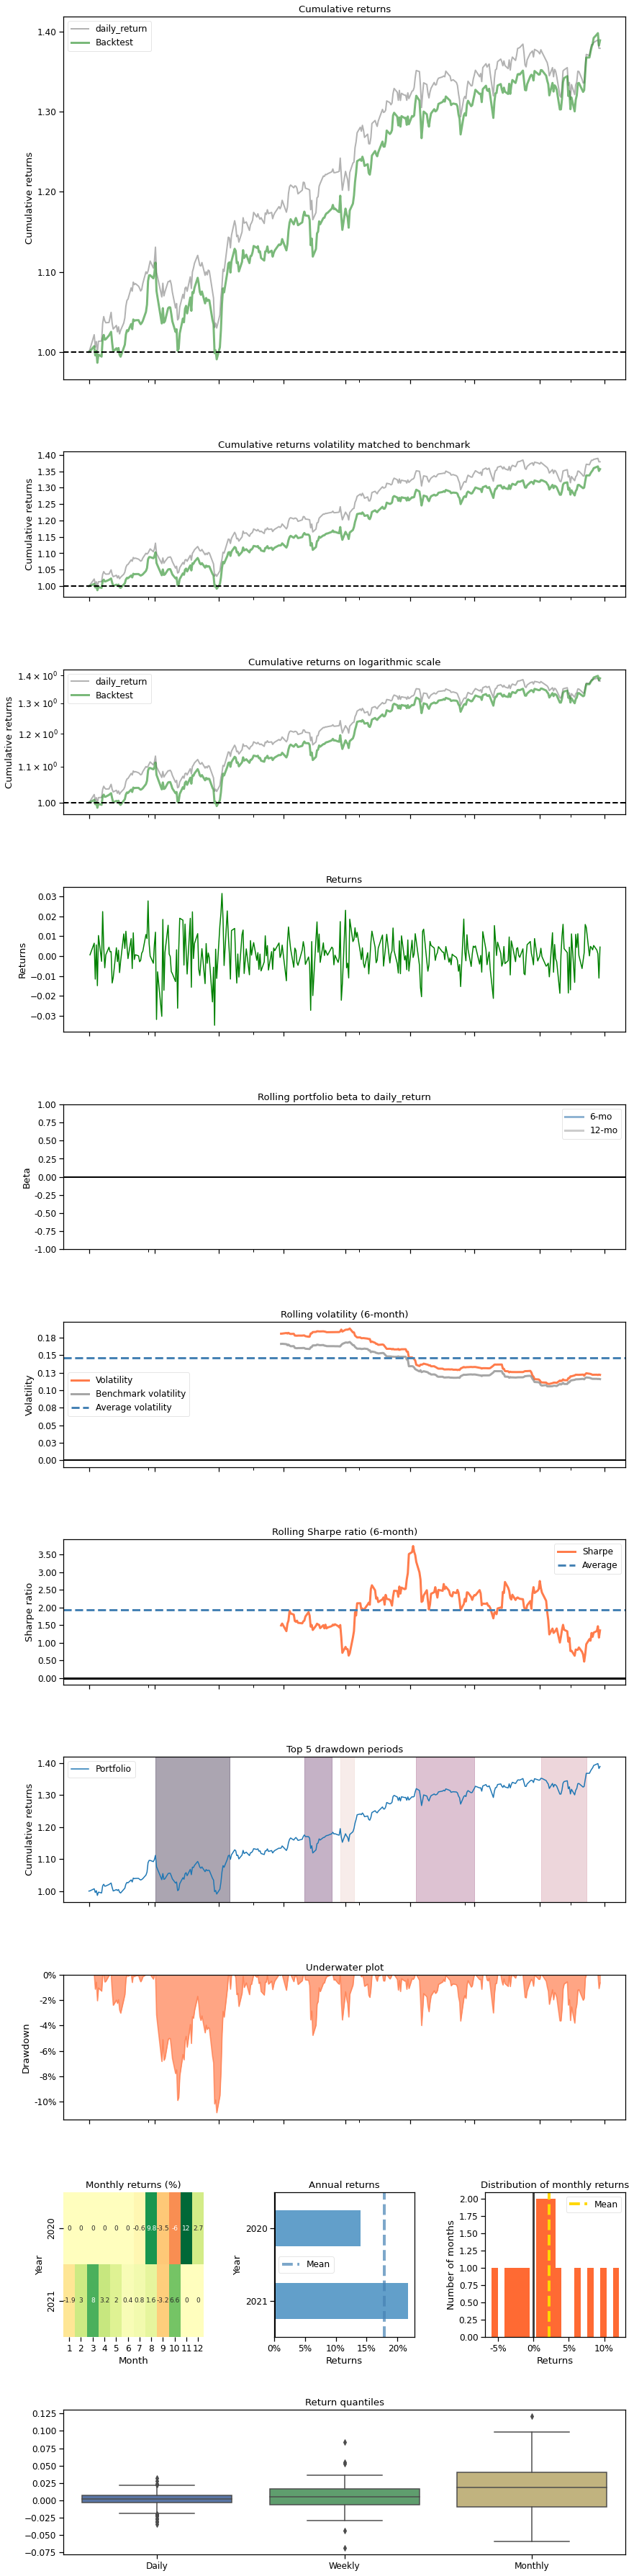

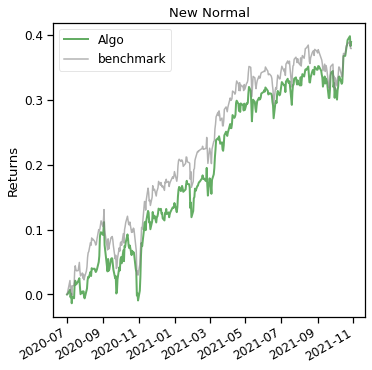

In [30]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])